In [2]:
pip install kaggle

In [3]:
pip install torchvision

In [9]:
!kaggle datasets download tawsifurrahman/covid19-radiography-database

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [2]:
!unzip covid19-radiography-database.zip -d covid19-radiography-database

Streaming output truncated to the last 5000 lines.
  inflating: covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: covid19-radiograph

In [3]:
!ls covid19-radiography-database

COVID-19_Radiography_Dataset


Image size: (299, 299)


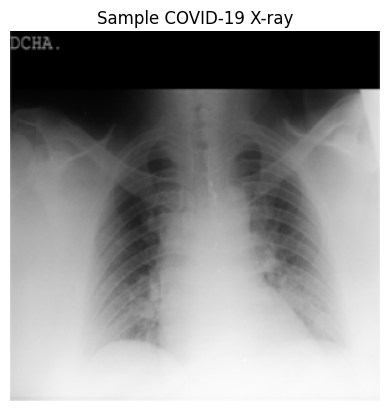

In [4]:
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt

covid_path = "./covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images"
covid_images = glob.glob(os.path.join(covid_path, "*.png"))

# Display one image
if covid_images:
    sample_img_path = covid_images[0]
    img = Image.open(sample_img_path)
    print(f"Image size: {img.size}")  # (width, height)
    plt.imshow(img, cmap="gray")
    plt.title("Sample COVID-19 X-ray")
    plt.axis("off")
    plt.show()
else:
    print("No images found at the specified path.")

In [5]:
import os
import glob
import random
import shutil

# from torchvision import extension

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import torch.nn as nn
import torch.optim as optim
from torchvision import models


from sklearn.model_selection import train_test_split


SEED = 42

# 1. Set Python built-in random seed
random.seed(SEED)

# 2. Set NumPy random seed
np.random.seed(SEED)

# 3. Set PyTorch random seed
torch.manual_seed(SEED)

# 4. If you are using CUDA on GPU
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# 5. Make sure cuDNN (if used) is deterministic
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [6]:
# Relative path to the base dataset folder
BASE_DATASET_DIR = "./covid19-radiography-database/COVID-19_Radiography_Dataset"

# Label-to-integer mapping
class_to_idx = {
    "Normal": 0,
    "Viral Pneumonia": 1,
    "COVID": 2,
    "Lung_Opacity": 3
}

# Inverse mapping if needed
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Collect (img_path, label) in a list
all_data = []
for class_name, label_idx in class_to_idx.items():
    # Folder for that class, e.g. "NORMAL", "PNEUMONIA", etc.
    class_folder = os.path.join(BASE_DATASET_DIR, class_name, "masks")

    # Collect all PNG or JPG files (adjust if needed)
    # Some data might be .png, others .jpg, so you could do both
    image_files_png = glob.glob(os.path.join(class_folder, "*.png"))
#     image_files_jpg = glob.glob(os.path.join(class_folder, "*.jpg"))
    image_files = image_files_png

    for img_path in image_files:
        all_data.append((img_path, label_idx))

print(f"Total number of images: {len(all_data)}")


Total number of images: 21165


In [7]:
import torchvision.transforms as T

# Shuffle the data first (just to be safe)
random.shuffle(all_data)

# Separate X (paths) and y (labels)
X = [item[0] for item in all_data]
y = [item[1] for item in all_data]

# First split to get train vs remainder
X_train, X_rem, y_train, y_rem = train_test_split(
    X, y,
    test_size=0.30,        # 30% remains for cal+test
    random_state=42,       # for reproducibility
    stratify=y             # keep class proportions
)

# Among the remainder, split calibration vs test
# If we want 10% of the total for calibration and 20% for test,
# that means calibration is 1/3 of the remainder
cal_size = 0.3333
X_cal, X_test, y_cal, y_test = train_test_split(
    X_rem, y_rem,
    test_size=1 - cal_size,
    random_state=42,
    stratify=y_rem
)

print(f"Train size: {len(X_train)}")
print(f"Calibration size: {len(X_cal)}")
print(f"Test size: {len(X_test)}")


Train size: 14815
Calibration size: 2116
Test size: 4234


In [8]:
class ChestXRayDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label


In [9]:
train_transform = T.Compose([
    T.Resize((299, 299)),                      # Change to 299x299 for Inception v3.
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

test_transform = T.Compose([
    T.Resize((299, 299)),                      # Also resize test images to 299x299.
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])


train_dataset = ChestXRayDataset(X_train, y_train, transform=train_transform)
cal_dataset   = ChestXRayDataset(X_cal,   y_cal,   transform=test_transform)
test_dataset  = ChestXRayDataset(X_test,  y_test,  transform=test_transform)


In [10]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
cal_loader   = DataLoader(cal_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("DataLoaders created.")
print("Train batches:", len(train_loader))
print("Cal batches:", len(cal_loader))
print("Test batches:", len(test_loader))


DataLoaders created.
Train batches: 463
Cal batches: 67
Test batches: 133


In [11]:
from collections import Counter

print("Train label distribution:", Counter(y_train))
print("Cal   label distribution:", Counter(y_cal))
print("Test  label distribution:", Counter(y_test))


Train label distribution: Counter({0: 7134, 3: 4208, 2: 2531, 1: 942})
Cal   label distribution: Counter({0: 1019, 3: 601, 2: 362, 1: 134})
Test  label distribution: Counter({0: 2039, 3: 1203, 2: 723, 1: 269})


In [12]:
# Load a pre-trained Inception v3
model = models.inception_v3(pretrained=True, aux_logits=True)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 234MB/s] 


In [13]:
# Replace the final fully connected layer
num_features = model.fc.in_features  # should be 2048
model.fc = nn.Linear(num_features, 4)
model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, 4)
print(num_features)

2048


In [14]:
for param in model.parameters():
    param.requires_grad = False

# Now unfreeze only the final fc layer
for param in model.fc.parameters():
    param.requires_grad = True


In [15]:
criterion = nn.CrossEntropyLoss()

# If only the fc layer is unfrozen:
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)

# If more layers are unfrozen:
# optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass returns outputs AND aux_outputs
        outputs, aux_outputs = model(images)

        # Compute losses for main output and aux output, then sum
        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux_outputs, labels)
        loss = loss1 + 0.4 * loss2  # standard weighting as recommended by Inception paper

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Stats
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%")

    # Optional: Evaluate on calibration set for early stopping or calibration stats
    # ...


cuda
Epoch 1/10 - Loss: 1.7546, Acc: 51.34%
Epoch 2/10 - Loss: 1.6523, Acc: 57.47%
Epoch 3/10 - Loss: 1.6079, Acc: 59.10%
Epoch 4/10 - Loss: 1.5795, Acc: 60.65%
Epoch 5/10 - Loss: 1.5637, Acc: 61.38%
Epoch 6/10 - Loss: 1.5569, Acc: 61.59%
Epoch 7/10 - Loss: 1.5416, Acc: 62.01%
Epoch 8/10 - Loss: 1.5350, Acc: 61.91%
Epoch 9/10 - Loss: 1.5332, Acc: 62.17%
Epoch 10/10 - Loss: 1.5285, Acc: 62.57%


In [17]:
from sklearn.metrics import confusion_matrix

def evaluate_on_test(model, test_loader, device):
    model.eval()  # set model to evaluation mode
    test_correct = 0
    test_total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

            # Collect for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100.0 * test_correct / test_total
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", cm)

    return accuracy, cm

In [18]:
accuracy, cm = evaluate_on_test(model, test_loader, device)

Test Accuracy: 65.04%
Confusion Matrix:
 [[1816   34    5  184]
 [  98  150    0   21]
 [ 456    3   26  238]
 [ 425    5   11  762]]


In [19]:
path="my_inception_model.pth"
"""
Saves the state dict of the model.
"""
torch.save(model.state_dict(), path)
print(f"Model saved to {path}.")



Model saved to my_inception_model.pth.


In [20]:
# First, reconstruct the same model structure with pretrained=True
model = models.inception_v3(pretrained=True, aux_logits=True)

# Replace final fully-connected layers to match your original training:
model.fc = nn.Linear(model.fc.in_features, 4)
model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, 4)

# Load your saved weights (state_dict)
path = "my_inception_model.pth"
model.load_state_dict(torch.load(path))

# Set to evaluation mode
model.to(device)
model.eval()

print("Model loaded successfully.")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded successfully.


In [21]:
accuracy, cm = evaluate_on_test(model, test_loader, device)

Test Accuracy: 65.04%
Confusion Matrix:
 [[1816   34    5  184]
 [  98  150    0   21]
 [ 456    3   26  238]
 [ 425    5   11  762]]


In [22]:
import torch
import numpy as np

def get_probs_and_labels(model, data_loader, device):
    """
    Runs the model on data_loader, returns:
      - probs_arr: N x C array of softmax probabilities
      - labels_arr: N array of ground truth labels
    where N is the number of samples, C is the number of classes.
    """
    model.eval()
    probs_list = []
    labels_list = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Convert logits to probabilities via softmax
            probs = torch.softmax(outputs, dim=1)

            # Move to CPU and convert to NumPy
            probs_list.append(probs.cpu().numpy())
            labels_list.append(labels.cpu().numpy())

    # Concatenate all batches
    probs_arr = np.concatenate(probs_list, axis=0)
    labels_arr = np.concatenate(labels_list, axis=0)

    return probs_arr, labels_arr

# Suppose 'model' is already trained & loaded
cal_probs, cal_labels   = get_probs_and_labels(model, cal_loader,  device)
test_probs, test_labels = get_probs_and_labels(model, test_loader, device)

print("Calibration set:", cal_probs.shape, cal_labels.shape)
print("Test set:", test_probs.shape, test_labels.shape)


Calibration set: (2116, 4) (2116,)
Test set: (4234, 4) (4234,)


In [23]:
# utils.py

import torch

# Suppose our 4 classes are:
# 0 = Normal, 1 = Pneumonia, 2 = COVID-19, 3 = Lung Opacity
# And 4 actions: 0 = No Action, 1 = Antibiotics, 2 = Quarantine & Supportive, 3 = Additional Testing

# Utility matrix: U[true_label][action]
UTILITY_MATRIX = [
    [10,  2,  2,  4],  # Normal
    [ 0,  10,  3,  7],  # Pneumonia
    [ 0,  3,  10,  8],  # COVID-19
    [ 1,  4,  4,  10]   # Lung Opacity
]

def compute_utility(action, true_label):
    """
    Returns the utility for the (true_label, action) pair.
    """
    return UTILITY_MATRIX[true_label][action]


**Implementation of the best response baseline.:**

In [24]:
import numpy as np
import torch
from collections import defaultdict, Counter

def evaluate_baseline_best_response(probs, labels, alpha=0.9, device='cpu'):
    """
    Baseline: for each sample, pick the action 'a' that maximizes the *expected utility*:
        E[u(a,y)] = sum_y p[y] * U[y,a].
    Then measure average utility, label/action counts, utility histogram, etc.

    Reports:
    - Average utility
    - Label counts vs. Action counts
    - Utility histogram & empirical PDF
    - alpha-quantile
    """
    # If probs or labels are torch tensors on GPU, bring them to CPU numpy
    if isinstance(probs, torch.Tensor):
        probs = probs.detach().to(device).cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.detach().to(device).cpu().numpy()

    num_samples = len(labels)
    # We assume 4 actions: 0,1,2,3 (No Action, Antibiotics, Quarantine, Additional Testing)
    actions = [0, 1, 2, 3]

    # 1) For each sample, pick the action that maximizes expected utility
    predicted_actions = []
    for i in range(num_samples):
        p_i = probs[i]  # shape (4,) for the 4 classes
        best_a = None
        best_value = -float('inf')
        for a in actions:
            # compute expected utility for action 'a'
            # E[u(a,y)] = sum_{y=0..3} p_i[y] * utility[y][a]
            # We'll just loop or do a dot product
            e_u = 0.0
            for y_idx, p_val in enumerate(p_i):
                e_u += p_val * compute_utility(a, y_idx)

            if e_u > best_value:
                best_value = e_u
                best_a = a

        predicted_actions.append(best_a)

    # 2) Compute realized utility for each sample
    utilities = []
    for i in range(num_samples):
        true_lbl = int(labels[i])
        act = int(predicted_actions[i])
        u_val = compute_utility(act, true_lbl)
        utilities.append(u_val)

    # 3) Summaries: average utility, label/action counts, histograms, etc.
    total_utility = np.sum(utilities)
    avg_utility = total_utility / num_samples if num_samples > 0 else 0.0

    label_counts = Counter(labels)
    action_counts = defaultdict(Counter)

    for i in range(num_samples):
        lbl = int(labels[i])
        act = int(predicted_actions[i])
        action_counts[lbl][act] += 1

    # Utility histogram
    utility_histogram = Counter(utilities)
    total_utilities = sum(utility_histogram.values())
    utility_pdf = {u: count / total_utilities for u, count in utility_histogram.items()}

    # alpha-Quantile
    sorted_utilities = sorted(utilities)
    alpha_quantile = float(np.quantile(sorted_utilities, alpha)) if len(sorted_utilities) > 0 else 0.0

    # 4) Print the report
    print("=== Baseline: Expected-Utility Responder ===")
    print(f"Average Utility = {avg_utility:.4f}\n")

    # True label distribution
    print("True Label Counts:")
    for lbl in sorted(label_counts.keys()):
        print(f"  Label {lbl}: {label_counts[lbl]}")
    print("")

    # Action distribution within each true label
    print("Action Counts per True Label:")
    for lbl in sorted(action_counts.keys()):
        actions_str = ", ".join(
            [f"Action {act} -> {action_counts[lbl][act]}" for act in sorted(action_counts[lbl].keys())]
        )
        print(f"  Label {lbl}: {actions_str}")
    print("")

    # Utility histogram & PDF
    print("Utility Histogram (Utility -> Count):")
    for u in sorted(utility_histogram.keys()):
        print(f"  {u}: {utility_histogram[u]}")
    print("")

    print("Utility PDF (Empirical Distribution):")
    for u in sorted(utility_pdf.keys()):
        print(f"  Utility {u}: {utility_pdf[u]:.4f}")
    print("")

    print(f"Alpha-Quantile ({alpha*100:.1f}%): {alpha_quantile:.4f}")

    return avg_utility, label_counts, action_counts, utility_histogram, utility_pdf, alpha_quantile


In [25]:
# Example usage:

# from evaluate_baselines import evaluate_baseline_best_response

# Evaluate on calibration data
_ = evaluate_baseline_best_response(cal_probs, cal_labels, alpha=0.1, device='cpu')

# Evaluate on test data
_ = evaluate_baseline_best_response(test_probs, test_labels, alpha=0.1, device='cpu')


=== Baseline: Expected-Utility Responder ===
Average Utility = 7.6895

True Label Counts:
  Label 0: 1019
  Label 1: 134
  Label 2: 362
  Label 3: 601

Action Counts per True Label:
  Label 0: Action 0 -> 640, Action 1 -> 6, Action 3 -> 373
  Label 1: Action 0 -> 13, Action 1 -> 30, Action 3 -> 91
  Label 2: Action 0 -> 108, Action 3 -> 254
  Label 3: Action 0 -> 68, Action 3 -> 533

Utility Histogram (Utility -> Count):
  0: 121
  1: 68
  2: 6
  4: 373
  7: 91
  8: 254
  10: 1203

Utility PDF (Empirical Distribution):
  Utility 0: 0.0572
  Utility 1: 0.0321
  Utility 2: 0.0028
  Utility 4: 0.1763
  Utility 7: 0.0430
  Utility 8: 0.1200
  Utility 10: 0.5685

Alpha-Quantile (10.0%): 4.0000
=== Baseline: Expected-Utility Responder ===
Average Utility = 7.7263

True Label Counts:
  Label 0: 2039
  Label 1: 269
  Label 2: 723
  Label 3: 1203

Action Counts per True Label:
  Label 0: Action 0 -> 1328, Action 1 -> 16, Action 3 -> 695
  Label 1: Action 0 -> 31, Action 1 -> 79, Action 3 -> 159

**Implementation of the RAC** (in the following multiple cells)

---



---



In [26]:
import math
import numpy as np

def hbtheta_and_arg(t, actions, f_x, utility_fn):
    """
    Compute (hbtheta_value, best_action) for a single x,t.

    :param t: float in [0,1], feasibility threshold
    :param actions: iterable of possible actions (e.g. [0,1,2,3])
    :param f_x: 1D array-like of probabilities f_x[y], summing to ~1, for y in label space {0..len(f_x)-1}
    :param utility_fn: a function utility_fn(a,y) -> real number
    :return: (best_u, best_a)
      best_u = hbtheta(x,t)
      best_a = argmax action that achieves best_u
    """

    # Convert f_x to a numpy array for vector operations (if not already)
    f_x = np.array(f_x, dtype=float)

    # We'll assume the label space is y in [0..len(f_x)-1].
    Y = np.arange(len(f_x))

    best_u = -math.inf
    best_a = None

    for a in actions:
        # 1) Compute utility for each label y
        #    shape: (len(Y),)
        utilities_for_a = np.array([utility_fn(a, y) for y in Y], dtype=float)

        # 2) Get unique utility values in descending order
        #    e.g. [9, 8, 4, 0, ...]
        unique_util_vals = np.unique(utilities_for_a)
        unique_util_vals = np.sort(unique_util_vals)[::-1]  # descending

        # 3) For each candidate utility value, check if sum_{y : utility>=candidate} f_x[y] >= t
        candidate_u = -math.inf
        for u_candidate in unique_util_vals:
            # Create a boolean mask for labels where utility >= u_candidate
            mask = (utilities_for_a >= u_candidate)
            sum_prob = np.sum(f_x[mask])

            if sum_prob >= t:
                candidate_u = u_candidate
                break  # no need to check smaller utilities

        # 4) Compare across actions
        if candidate_u > best_u:
            best_u = candidate_u
            best_a = a

    return best_u, best_a


In [27]:
import numpy as np
import math

def compute_g_hat(x_probs, beta, actions, utility_fn):
    """
    Compute g_hat(x, beta) = argmax_{s in [0,1]} [ beta*s + h_btheta(x, s) ]
    using only the *relevant* thresholds derived from T(a, u).

    :param x_probs: 1D array-like of probabilities f_x[y], sums to 1
    :param beta: float parameter in [0, 2] (or any real range)
    :param actions: list/iterable of possible actions
    :param utility_fn: function utility_fn(a,y) -> float
    :return: s_star in [0,1] that maximizes beta*s + h_btheta(x, s)

    Explanation:
      - We do NOT search a full grid of 101 points.
      - Instead, for each action a, we gather unique utility values u in descending order,
        compute T(a,u) = sum_{y : utility(a,y) >= u} x_probs[y].
      - h_btheta(x, s) changes only at these T(a,u) thresholds (plus possibly 0 or 1).
      - We then evaluate phi(s) = beta*s + h_btheta(x, s) only at these discrete s-values.
      - The s that yields the highest phi(s) is returned.
    """
    x_probs = np.asarray(x_probs, dtype=float)
    num_labels = len(x_probs)

    # 1) For each action 'a', gather unique utility values + compute T(a,u).
    #    We'll store them in descending order of u so we can quickly parse them.
    #    T(a,u) = sum_{y : utility_fn(a,y) >= u} x_probs[y].
    action_thresholds = {}  # action -> list of (u, T(a,u)) in descending order of u
    all_s_candidates = set([0.0, 1.0])  # we'll include 0 and 1 from the start

    for a in actions:
        # Compute utility for each label y
        utilities_for_a = np.array([utility_fn(a, y) for y in range(num_labels)], dtype=float)

        # Gather unique utilities in descending order
        unique_utils = np.unique(utilities_for_a)
        unique_utils = np.sort(unique_utils)[::-1]  # descending

        # For each u_candidate, compute T(a,u_candidate)
        pairs = []
        for u_candidate in unique_utils:
            mask = (utilities_for_a >= u_candidate)
            t_val = x_probs[mask].sum()
            pairs.append((u_candidate, t_val))
            # This t_val is a potential candidate s
            all_s_candidates.add(float(t_val))  # add to global set of s-candidates

        action_thresholds[a] = pairs  # list of (u, T(a,u)) in descending order of u

    # 2) Now we have a set of possible s in [0,1], including T(a,u) for all a,u plus {0,1}.
    #    We'll evaluate phi(s) = beta*s + h_btheta(x, s) at each candidate.
    #    h_btheta(x, s) = max_{a} [ largest u in pairs for which T(a,u) >= s ]

    s_star = 0.0
    best_score = -math.inf

    # We'll convert to a sorted list (ascending or random). Ascending is typical:
    s_candidates = sorted(all_s_candidates)

    for s in s_candidates:
        # Compute h_btheta(x, s)
        # For each action a, find the largest u s.t. T(a,u) >= s
        best_u_for_s = -math.inf

        for a, pairs in action_thresholds.items():
            # 'pairs' is in descending order of u, so T(a,u) is presumably non-increasing as we go
            # from bigger to smaller u. We'll do a quick linear scan:
            feasible_u = -math.inf
            for (u_candidate, t_val) in pairs:
                if t_val >= s:
                    feasible_u = u_candidate
                    break
            if feasible_u > best_u_for_s:
                best_u_for_s = feasible_u

        # Now we have h_btheta(x, s) = best_u_for_s
        # phi(s) = beta*s + best_u_for_s
        phi_s = beta*s + best_u_for_s

        if phi_s > best_score:
            best_score = phi_s
            s_star = s

    return s_star


In [29]:
from tqdm import tqdm

def get_conformal_set(x_probs, s_value, actions, utility_fn):
    """
    Vectorized approach:
      1) (best_u, best_a) = hbtheta_and_arg(s_value, actions, x_probs, utility_fn)
      2) u_vec[y] = utility_fn(best_a, y)
      3) y in c_star if sum_{y': u_vec[y'] >= u_vec[y]} x_probs[y'] >= s_value
    """
    num_labels = len(x_probs)
    best_u, best_a = hbtheta_and_arg(s_value, actions, x_probs, utility_fn)

    # Vector of shape (num_labels,) for this chosen action
    u_vec = np.array([utility_fn(best_a, y) for y in range(num_labels)], dtype=float)

    c_star = set()

    # We can do an O(num_labels^2) approach with vector masks:
    for y in range(num_labels):
        val_y = u_vec[y]
        mask = (u_vec > val_y)   # vector mask
        sum_prob = x_probs[mask].sum()
        if sum_prob <= s_value:
            c_star.add(y)

    return c_star

def get_conformal_set(x_probs, s_value, actions, utility_fn):
    """
    Vectorized approach:
      1) (best_u, best_a) = hbtheta_and_arg(s_value, actions, x_probs, utility_fn)
      2) u_vec[y] = utility_fn(best_a, y)
      3) y in c_star if sum_{y': u_vec[y'] >= u_vec[y]} x_probs[y'] >= s_value
    """
    num_labels = len(x_probs)
    best_u, best_a = hbtheta_and_arg(s_value, actions, x_probs, utility_fn)

    # Vector of shape (num_labels,) for this chosen action
    u_vec = np.array([utility_fn(best_a, y) for y in range(num_labels)], dtype=float)

    c_star = set()

    # We can do an O(num_labels^2) approach with vector masks:
    for y in range(num_labels):
        val_y = u_vec[y]
        mask = (u_vec > val_y)   # vector mask
        sum_prob = x_probs[mask].sum()
        if sum_prob <= s_value:
            c_star.add(y)

    return c_star


def coverage_for_beta(calib_probs, calib_labels, beta, actions, utility_fn):
    """
    :param calib_probs: list (or array) of length n,
        each element is x_probs[i], i.e. array of shape (num_labels,).
    :param calib_labels: list/array of length n with the true label index for each sample
    :param beta: float
    :param actions: list of possible actions
    :param utility_fn: ...
    :return: coverage in [0,1]
    """
    n = len(calib_probs)
    hits = 0
    for i in range(n):
        x_probs_i = calib_probs[i]
        y_i       = calib_labels[i]

        # compute s_i = g_hat(x, beta)
        s_i = compute_g_hat(x_probs_i, beta, actions, utility_fn)
        # get the set
        c_star_i = get_conformal_set(x_probs_i, s_i, actions, utility_fn)

        # check coverage
        if y_i in c_star_i:
            hits += 1
    return hits / n


def find_threshold_q(calib_probs, calib_labels, alpha, actions, utility_fn, beta_step=0.01, max_beta=2.0):
    """
    Sweep beta from 0..max_beta with step size = beta_step.
    For each beta, compute coverage.
    Return the FIRST beta where coverage >= 1 - alpha.

    :param calib_probs: list/array of shape (n,), each is an array (num_labels,) for x_probs
    :param calib_labels: list/array of shape (n,) with the true label index
    :param alpha: in [0,1]
    :param actions: ...
    :param utility_fn: ...
    :param beta_step: step size for the grid
    :param max_beta: max for the grid
    :return: q (float) or None if not found
    """
    beta_val_now = 1
    beta_val_past = 0

    cov = coverage_for_beta(calib_probs, calib_labels, beta_val_now, actions, utility_fn)

    while cov < 1 - alpha:
        beta_val_past = beta_val_now
        beta_val_now = beta_val_now *2
        cov = coverage_for_beta(calib_probs, calib_labels, beta_val_now, actions, utility_fn)

    for T in range(20):
        beta_val_mean = (beta_val_past + beta_val_now)/2
        cov = coverage_for_beta(calib_probs, calib_labels, beta_val_mean, actions, utility_fn)
        if cov >= (1.0 - alpha):
            beta_val_now = beta_val_mean
        else:
            beta_val_past = beta_val_mean

    # If we never reached coverage
    return (beta_val_past + beta_val_now)/2


In [30]:
import numpy as np
from collections import defaultdict, Counter

def evaluate_test_set(
    test_probs,
    test_labels,
    q,
    actions,
    utility_fn,
    alpha
):
    """
    Evaluate the conformal-based policy on the test set, then report
    performance metrics similar to the 'best responder' baseline:
      - Test coverage
      - Average utility
      - True label counts
      - Action counts per true label
      - Utility histogram & PDF
      - alpha-Quantile of realized utilities
      - Average max-min value

    :param test_probs: list/array of shape (num_test_samples,),
                       each an array (num_labels,) of probabilities
    :param test_labels: list/array of shape (num_test_samples,)
                        with the true label indices
    :param q: the threshold from calibration (beta or "q")
    :param actions: list/iterable of possible actions (e.g., [0,1,2,3])
    :param utility_fn: function utility_fn(a, y) -> real
    :param alpha: float in [0,1], for quantile
    :return: A dictionary with
             "avg_maxmin_value", "coverage", "avg_utility", "utility_quantile",
             "label_counts", "action_counts", "utility_histogram", "utility_pdf".
    """
    total_samples = len(test_probs)
    cover_hits = 0
    total_utility = 0.0

    # We collect realized utilities and max-min values
    realized_utilities = []
    max_min_values = []
    set_size_values = []

    # We'll track label and action counts
    label_counts = Counter()
    action_counts = defaultdict(Counter)

    # Precompute number of labels
    num_labels = len(test_probs[0]) if total_samples > 0 else 0

    for i in range(total_samples):
        x_probs = test_probs[i]
        y_true  = test_labels[i]

        # 1) Count true label
        label_counts[y_true] += 1

        # 2) Compute g_hat => s_test
        s_test = compute_g_hat(x_probs, q, actions, utility_fn)

        # 3) Find (nu_star, a_star)
        nu_star, a_star = hbtheta_and_arg(s_test, actions, x_probs, utility_fn)
        max_min_values.append(nu_star)

        # 4) Build c_star
        c_star = get_conformal_set(x_probs, s_test, actions, utility_fn)

        set_size_values.append(len(c_star))

        # Coverage check
        if y_true in c_star:
            cover_hits += 1

        # Realized utility
        u_val = utility_fn(a_star, y_true)
        total_utility += u_val
        realized_utilities.append(u_val)

        # Action count for each true label
        action_counts[y_true][a_star] += 1

    # Compute coverage
    test_coverage = cover_hits / total_samples if total_samples > 0 else 0.0
    # Average utility
    avg_utility = total_utility / total_samples if total_samples > 0 else 0.0
    # Average max-min value
    avg_max_min_value = np.mean(max_min_values) if len(max_min_values) > 0 else 0.0

    avg_set_size_value = np.mean(set_size_values) if len(set_size_values) > 0 else 0.0

    # Utility histogram & PDF
    utility_histogram = Counter(realized_utilities)
    total_hist_count = sum(utility_histogram.values())
    utility_pdf = {u: cnt / total_hist_count for u, cnt in utility_histogram.items()}

    # alpha-quantile of realized utilities
    sorted_utils = sorted(realized_utilities)
    utility_quantile = float(np.quantile(sorted_utils, alpha)) if len(sorted_utils) > 0 else 0.0

    # === Print the report ===
    print("=== Conformal-Based Evaluation ===")
    print(f"Coverage = {test_coverage:.3f}")
    print(f"Average Utility = {avg_utility:.4f}")
    print(f"Average Max–Min Value = {avg_max_min_value:.4f}\n")
    print(f"Average set size = {avg_set_size_value:.4f}\n")


    # True label distribution
    print("True Label Counts:")
    for lbl in sorted(label_counts.keys()):
        print(f"  Label {lbl}: {label_counts[lbl]}")
    print("")

    # Action distribution within each true label
    print("Action Counts per True Label:")
    for lbl in sorted(action_counts.keys()):
        acts_str = ", ".join(
            [f"Action {act} -> {action_counts[lbl][act]}" for act in sorted(action_counts[lbl].keys())]
        )
        print(f"  Label {lbl}: {acts_str}")
    print("")

    print("Utility Histogram (Utility -> Count):")
    for val in sorted(utility_histogram.keys()):
        print(f"  {val}: {utility_histogram[val]}")
    print("")

    print("Utility PDF (Empirical Distribution):")
    for u in sorted(utility_pdf.keys()):
        print(f"  Utility {u}: {utility_pdf[u]:.4f}")
    print("")

    print(f"Alpha-Quantile ({alpha*100:.1f}%): {utility_quantile:.4f}\n")

    # Return the stats in a dictionary
    return {
        "avg_maxmin_value": avg_max_min_value,
        "coverage": test_coverage,
        "avg_utility": avg_utility,
        "utility_quantile": utility_quantile,
        "label_counts": label_counts,
        "action_counts": action_counts,
        "utility_histogram": utility_histogram,
        "utility_pdf": utility_pdf
    }


In [31]:
def run_conformal_evaluation(
    calib_probs, calib_labels,
    test_probs,  test_labels,
    alpha, actions, utility_fn,
    beta_step=0.01, max_beta=2.0
):
    """
    1) find q
    2) evaluate on test set
    3) return (q, results)
    """
    q = find_threshold_q(calib_probs, calib_labels, alpha, actions, utility_fn,
                         beta_step=beta_step, max_beta=max_beta)
    results = evaluate_test_set(test_probs, test_labels, q, actions, utility_fn, alpha)
    return q, results

An example.

In [32]:
actions = [0, 1, 2, 3]
alpha = 0.05

# 1) Find q via "run_conformal_evaluation"
#    The code will call 'find_threshold_q' -> 'coverage_for_beta' -> 'compute_g_hat_optimized'
q, results = run_conformal_evaluation(
    calib_probs=cal_probs,
    calib_labels=cal_labels,
    test_probs=test_probs,
    test_labels=test_labels,
    alpha=alpha,
    actions=actions,
    utility_fn=compute_utility,
    beta_step=0.01,
    max_beta=2.0
)

print("\n=== Final Results ===")
print(f"Chosen q = {q}")
print("Metrics on test set:", results)


=== Conformal-Based Evaluation ===
Coverage = 0.947
Average Utility = 7.6138
Average Max–Min Value = 6.7012

Average set size = 3.1464

True Label Counts:
  Label 0: 2039
  Label 1: 269
  Label 2: 723
  Label 3: 1203

Action Counts per True Label:
  Label 0: Action 0 -> 1085, Action 1 -> 7, Action 3 -> 947
  Label 1: Action 0 -> 13, Action 1 -> 52, Action 3 -> 204
  Label 2: Action 0 -> 145, Action 3 -> 578
  Label 3: Action 0 -> 113, Action 3 -> 1090

Utility Histogram (Utility -> Count):
  0: 158
  1: 113
  2: 7
  4: 947
  7: 204
  8: 578
  10: 2227

Utility PDF (Empirical Distribution):
  Utility 0: 0.0373
  Utility 1: 0.0267
  Utility 2: 0.0017
  Utility 4: 0.2237
  Utility 7: 0.0482
  Utility 8: 0.1365
  Utility 10: 0.5260

Alpha-Quantile (5.0%): 1.0000


=== Final Results ===
Chosen q = 16.626365661621094
Metrics on test set: {'avg_maxmin_value': np.float64(6.701228153046764), 'coverage': 0.9468587623996221, 'avg_utility': 7.613840340103921, 'utility_quantile': 1.0, 'label_counts

**Implementing score-1 and score-2** (These are the other baselines we compare to)

In [33]:
import numpy as np

def compute_conformal_threshold_newscore(cal_probs, cal_labels, alpha=0.2):
    """
    Computes the threshold T for the "new non-conformity score":
      score(x, c) = sum of p_{c'}(x) for all c' != c where p_{c'}(x) > p_c(x)

    :param cal_probs: array/list of length N_cal, each entry is shape (num_labels,) with softmax probabilities
    :param cal_labels: array/list of length N_cal, each entry is an int label in [0..num_labels-1]
    :param alpha: float in [0,1], coverage parameter
    :return: float T, the (1 - alpha)-quantile of these scores
    """
    nonconformity_scores = []

    for i in range(len(cal_probs)):
        probs = cal_probs[i]       # shape (num_labels,)
        c_true = cal_labels[i]     # int
        p_true = probs[c_true]     # p_{c_true}(x)

        # score(x, c_true): sum_{c' != c_true : p_{c'}(x) > p_true} p_{c'}(x)
        mask = (probs > p_true)
        # Exclude the true class itself
        mask[c_true] = False
        score = np.sum(probs[mask])
        nonconformity_scores.append(score)

    nonconformity_scores = np.array(nonconformity_scores, dtype=float)

    # We want the (1-alpha) quantile. By default, NumPy uses the "linear" interpolation,
    # you can specify different methods if you prefer.
    # We'll pick 'higher' or a method that ensures coverage for conformal sets.
    T = float(np.quantile(nonconformity_scores, 1.0 - alpha, method='higher'))
    return T

def select_action_max_min(S_indices, actions, utility_fn):
    """
    Select an action a that maximizes min_{y in S_indices} utility_fn(a, y).

    :param S_indices: an iterable (set or list) of label indices
    :param actions: list/iterable of possible actions
    :param utility_fn: function utility_fn(a, y) -> float
    :return: (best_action, best_min_utility)
    """
    best_action = None
    best_min_util = float('-inf')

    for a in actions:
        # Compute the min utility over labels in S_indices
        min_util = float('inf')
        for y in S_indices:
            u_val = utility_fn(a, y)
            if u_val < min_util:
                min_util = u_val

        # Compare to our global best
        if min_util > best_min_util:
            best_min_util = min_util
            best_action = a

    return best_action, best_min_util



In [35]:
import numpy as np
from collections import defaultdict, Counter

def evaluate_conformal_policy_newscore(
    test_probs,       # shape (N_test,) each an array of size num_labels
    test_labels,      # shape (N_test,) each an int in [0..num_labels-1]
    T,                # threshold from compute_conformal_threshold_newscore
    actions,          # e.g. [0,1,2,3]
    utility_fn,       # utility_fn(a, y)
    alpha=0.2
):
    """
    Evaluate the conformal policy (newscore) on the test set with a max–min action selection:
     - For each x, we build S(x). Coverage check is y_true in S(x)?
     - Then we pick final_action = argmax_{a} min_{y in S(x)} u(a, y).
       (Fallback to the entire label set if S(x) is empty.)

    Reports:
      - Coverage
      - Average utility
      - Average max–min value (for chosen action)
      - Label counts & Action counts
      - Utility histogram & PDF
      - alpha-Quantile of realized utilities
    """
    from collections import defaultdict, Counter

    num_test = len(test_probs)
    if num_test == 0:
        print("Warning: Empty test set!")
        return {}

    coverage_hits = 0
    total_utility = 0.0

    # We'll also keep track of the max–min utility values for each sample
    max_min_values = []

    # For reporting distribution stats
    realized_utilities = []
    label_counts = Counter()
    action_counts = defaultdict(Counter)

    num_labels = len(test_probs[0])  # assume consistent shape

    for i in range(num_test):
        probs = test_probs[i]      # shape (num_labels,)
        y_true = test_labels[i]
        label_counts[y_true] += 1

        # Step 1) Build S(x) = { c : score(x,c) <= T }
        # score(x, c) = sum_{c' != c : probs[c'] > probs[c]} probs[c']
        scores = np.zeros(num_labels, dtype=float)
        for c in range(num_labels):
            p_c = probs[c]
            mask = (probs > p_c)
            mask[c] = False
            scores[c] = np.sum(probs[mask])

        S_indices = np.where(scores <= T)[0]

        # coverage check
        if y_true in S_indices:
            coverage_hits += 1

        # fallback if S(x) is empty
        if len(S_indices) == 0:
            # fallback to all labels
            S_indices = np.arange(num_labels)

        # Step 2) Pick action using max–min rule
        a_star, mm_value = select_action_max_min(S_indices, actions, utility_fn)
        # store that max–min value (the worst-case among the labels in S_indices,
        # but best among the actions)
        max_min_values.append(mm_value)

        # Step 3) Realized utility with the chosen action
        u_val = utility_fn(a_star, y_true)
        realized_utilities.append(u_val)
        total_utility += u_val

        # Tally action counts
        action_counts[y_true][a_star] += 1

    # Coverage
    coverage = coverage_hits / num_test
    # Average Utility
    avg_utility = total_utility / num_test
    # Average of the max–min values
    avg_max_min_value = np.mean(max_min_values) if len(max_min_values) > 0 else 0.0

    # Utility histogram & PDF
    utility_histogram = Counter(realized_utilities)
    total_hist_count = sum(utility_histogram.values())
    utility_pdf = {u: cnt / total_hist_count for u, cnt in utility_histogram.items()}

    # alpha-Quantile of realized utilities
    sorted_utils = sorted(realized_utilities)
    if len(sorted_utils) > 0:
        utility_quantile = float(np.quantile(sorted_utils, alpha))
    else:
        utility_quantile = 0.0

    return {
        "coverage": coverage,
        "avg_utility": avg_utility,
        "avg_maxmin_value": avg_max_min_value,
        "utility_quantile": utility_quantile,
        "label_counts": label_counts,
        "action_counts": action_counts,
        "utility_histogram": utility_histogram,
        "utility_pdf": utility_pdf
    }


In [36]:
# 1) Compute the threshold T on the calibration set
alpha = 0.01
T = compute_conformal_threshold_newscore(
    cal_probs,   # e.g. shape (N_cal, 4)
    cal_labels,  # shape (N_cal,)
    alpha=alpha
)

# 2) Evaluate on the test set
actions = [0, 1, 2, 3]  # e.g. 4 actions

results_newscore = evaluate_conformal_policy_newscore(
    test_probs, test_labels,
    T=T,
    actions=actions,
    utility_fn=compute_utility,
    alpha=alpha
)


In [37]:
import numpy as np

def compute_conformal_threshold_1mptrue(cal_probs, cal_labels, alpha=0.2):
    """
    Computes threshold T from calibration set, based on the nonconformity score:
      score(x) = 1.0 - p_true(x)

    :param cal_probs: list or array of length N_cal,
                      each entry is shape (num_labels,) with softmax probabilities
    :param cal_labels: list or array of length N_cal
                      each entry is the true label in [0..num_labels-1]
    :param alpha: float in [0,1], coverage parameter
    :return: T, the (1-alpha) quantile of these scores
    """
    nonconformity_scores = []

    for i in range(len(cal_probs)):
        probs = cal_probs[i]       # shape (num_labels,)
        c_true = cal_labels[i]     # int label
        p_true = probs[c_true]     # Probability assigned to the correct label
        score = 1.0 - p_true
        nonconformity_scores.append(score)

    nonconformity_scores = np.array(nonconformity_scores, dtype=float)
    # Use method='higher' for a more conservative threshold (Python 3.8+)
    T = float(np.quantile(nonconformity_scores, 1.0 - alpha, method='higher'))
    return T


In [39]:
from collections import defaultdict, Counter

def evaluate_conformal_policy_1mptrue_maxmin(
    test_probs,    # shape (N_test,) each an array (num_labels,) of probabilities
    test_labels,   # shape (N_test,) each an int in [0..num_labels-1]
    T,             # threshold from compute_conformal_threshold_1mptrue
    actions,       # list/iterable of possible actions
    utility_fn,    # utility_fn(a, y)
    alpha
):
    """
    Evaluate the "1 - p_true" conformal policy on the test set with a max-min action rule:
      1) S(x) = { c : p[c] >= 1 - T }
      2) coverage if y_true in S(x)
      3) a_star = argmax_{a} min_{y in S(x)} u(a,y)  (fallback to global max-min if S(x) is empty)
      4) realized utility = u(a_star, y_true)

    Reports:
      - Coverage
      - Average Utility
      - Average Max-Min Value
      - Label counts & action counts
      - Utility histogram & PDF
      - alpha-Quantile of realized utilities
    """
    num_test = len(test_probs)
    if num_test == 0:
        print("Warning: empty test set!")
        return {}

    coverage_hits = 0
    total_utility = 0.0

    realized_utilities = []
    maxmin_values = []

    label_counts = Counter()
    action_counts = defaultdict(Counter)

    num_labels = len(test_probs[0])

    # Precompute a fallback if S(x) is empty => global max-min over all labels
    all_labels = np.arange(num_labels)
    fallback_a, fallback_val = select_action_max_min(all_labels, actions, utility_fn)

    for i in range(num_test):
        probs = test_probs[i]
        y_true = test_labels[i]
        label_counts[y_true] += 1

        # Build S(x) = { c : p[c] >= 1 - T }
        cutoff = 1.0 - T
        S_indices = np.where(probs >= cutoff)[0]

        # coverage
        if y_true in S_indices:
            coverage_hits += 1

        # max-min action selection
        if len(S_indices) > 0:
            a_star, a_star_val = select_action_max_min(S_indices, actions, utility_fn)
#             print(a_star_val)
#             print(S_indices, a_star_val, a_star)
        else:
            # fallback
            a_star, a_star_val = fallback_a, fallback_val


        maxmin_values.append(a_star_val)

        # realized utility
        u_val = utility_fn(a_star, y_true)
        realized_utilities.append(u_val)
        total_utility += u_val

        # action count
        action_counts[y_true][a_star] += 1

    coverage = coverage_hits / num_test
    avg_utility = total_utility / num_test
    avg_maxmin = np.mean(maxmin_values) if len(maxmin_values) > 0 else 0.0

    # Utility histogram & PDF
    utility_histogram = Counter(realized_utilities)
    total_hist_count = sum(utility_histogram.values())
    utility_pdf = {u: cnt / total_hist_count for u, cnt in utility_histogram.items()}

    # alpha-quantile
    sorted_utils = sorted(realized_utilities)
    if len(sorted_utils) > 0:
        utility_quantile = float(np.quantile(sorted_utils, alpha))
    else:
        utility_quantile = 0.0

    print("Utility PDF (Empirical Distribution):")
    for u in sorted(utility_pdf.keys()):
        print(f"  Utility {u}: {utility_pdf[u]:.4f}")
    print("")

    print(f"Alpha-Quantile ({alpha*100:.1f}%): {utility_quantile:.4f}\n")

    return {
        "coverage": coverage,
        "avg_utility": avg_utility,
        "avg_maxmin_value": avg_maxmin,
        "utility_quantile": utility_quantile,
        "label_counts": label_counts,
        "action_counts": action_counts,
        "utility_histogram": utility_histogram,
        "utility_pdf": utility_pdf
    }


In [40]:
# 1) Compute threshold T on calibration set
alpha = 0.1
T = compute_conformal_threshold_1mptrue(
    cal_probs,   # shape (N_cal, num_labels)
    cal_labels,  # shape (N_cal,)
    alpha=alpha
)

# 2) Evaluate on test set
# Define your actions [0,1,2,3], a 4x4 utility matrix, etc.
actions = [0,1,2,3]
results_1mptrue = evaluate_conformal_policy_1mptrue_maxmin(
    test_probs,  # shape (N_test, num_labels)
    test_labels, # shape (N_test,)
    T,
    actions,
    compute_utility,
    alpha=alpha
)


Utility PDF (Empirical Distribution):
  Utility 0: 0.0227
  Utility 1: 0.0163
  Utility 2: 0.0012
  Utility 4: 0.2959
  Utility 7: 0.0505
  Utility 8: 0.1509
  Utility 10: 0.4624

Alpha-Quantile (10.0%): 4.0000



In [41]:
actions = [0,1,2,3]
alpha_list = [0.001, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]

avg_b =[]
avg_ours =[]
avg_s1 =[]
avg_s2 =[]

q_b =[]
q_ours =[]
q_s1 =[]
q_s2 =[]

# avg_b =[]
max_ours =[]
max_s1 =[]
max_s2 =[]

for alpha in tqdm(alpha_list):

    q, results = run_conformal_evaluation(
    calib_probs=cal_probs,
    calib_labels=cal_labels,
    test_probs=test_probs,
    test_labels=test_labels,
    alpha=alpha,
    actions=actions,
    utility_fn=compute_utility,
    beta_step=0.01,
    max_beta=2.0
    )

    avg_ours.append(results['avg_utility'])
    q_ours.append(1 - results['coverage'])
    max_ours.append(results['avg_maxmin_value'])


    T = compute_conformal_threshold_1mptrue(
    cal_probs,   # shape (N_cal, num_labels)
    cal_labels,  # shape (N_cal,)
    alpha=alpha
    )

    results = evaluate_conformal_policy_1mptrue_maxmin(
    test_probs,  # shape (N_test, num_labels)
    test_labels, # shape (N_test,)
    T,
    actions,
    compute_utility,
    alpha=alpha
    )

    avg_s1.append(results['avg_utility'])
    q_s1.append(1 - results['coverage'])
    max_s1.append(results['avg_maxmin_value'])



    T = compute_conformal_threshold_newscore(
    cal_probs,   # e.g. shape (N_cal, 4)
    cal_labels,  # shape (N_cal,)
    alpha=alpha)

    results = evaluate_conformal_policy_newscore(
    test_probs, test_labels,
    T=T,
    actions=actions,
    utility_fn=compute_utility,
    alpha=alpha
    )

    avg_s2.append(results['avg_utility'])
    q_s2.append(1 - results['coverage'])
    max_s2.append(results['avg_maxmin_value'])



  0%|          | 0/7 [00:00<?, ?it/s]

=== Conformal-Based Evaluation ===
Coverage = 1.000
Average Utility = 6.5928
Average Max–Min Value = 4.0864

Average set size = 3.9816

True Label Counts:
  Label 0: 2039
  Label 1: 269
  Label 2: 723
  Label 3: 1203

Action Counts per True Label:
  Label 0: Action 0 -> 10, Action 3 -> 2029
  Label 1: Action 1 -> 3, Action 3 -> 266
  Label 2: Action 0 -> 1, Action 3 -> 722
  Label 3: Action 3 -> 1203

Utility Histogram (Utility -> Count):
  0: 1
  4: 2029
  7: 266
  8: 722
  10: 1216

Utility PDF (Empirical Distribution):
  Utility 0: 0.0002
  Utility 4: 0.4792
  Utility 7: 0.0628
  Utility 8: 0.1705
  Utility 10: 0.2872

Alpha-Quantile (0.1%): 4.0000

Utility PDF (Empirical Distribution):
  Utility 4: 0.4813
  Utility 7: 0.0631
  Utility 8: 0.1708
  Utility 10: 0.2848

Alpha-Quantile (0.1%): 4.0000



 14%|█▍        | 1/7 [00:21<02:09, 21.58s/it]

=== Conformal-Based Evaluation ===
Coverage = 0.998
Average Utility = 6.7234
Average Max–Min Value = 4.3217

Average set size = 3.9098

True Label Counts:
  Label 0: 2039
  Label 1: 269
  Label 2: 723
  Label 3: 1203

Action Counts per True Label:
  Label 0: Action 0 -> 110, Action 3 -> 1929
  Label 1: Action 1 -> 13, Action 3 -> 256
  Label 2: Action 0 -> 5, Action 3 -> 718
  Label 3: Action 0 -> 5, Action 3 -> 1198

Utility Histogram (Utility -> Count):
  0: 5
  1: 5
  4: 1929
  7: 256
  8: 718
  10: 1321

Utility PDF (Empirical Distribution):
  Utility 0: 0.0012
  Utility 1: 0.0012
  Utility 4: 0.4556
  Utility 7: 0.0605
  Utility 8: 0.1696
  Utility 10: 0.3120

Alpha-Quantile (0.5%): 4.0000

Utility PDF (Empirical Distribution):
  Utility 4: 0.4787
  Utility 7: 0.0614
  Utility 8: 0.1708
  Utility 10: 0.2891

Alpha-Quantile (0.5%): 4.0000



 29%|██▊       | 2/7 [00:45<01:54, 22.99s/it]

=== Conformal-Based Evaluation ===
Coverage = 0.990
Average Utility = 6.9131
Average Max–Min Value = 4.7447

Average set size = 3.7796

True Label Counts:
  Label 0: 2039
  Label 1: 269
  Label 2: 723
  Label 3: 1203

Action Counts per True Label:
  Label 0: Action 0 -> 287, Action 1 -> 1, Action 3 -> 1751
  Label 1: Action 1 -> 19, Action 3 -> 250
  Label 2: Action 0 -> 27, Action 3 -> 696
  Label 3: Action 0 -> 16, Action 3 -> 1187

Utility Histogram (Utility -> Count):
  0: 27
  1: 16
  2: 1
  4: 1751
  7: 250
  8: 696
  10: 1493

Utility PDF (Empirical Distribution):
  Utility 0: 0.0064
  Utility 1: 0.0038
  Utility 2: 0.0002
  Utility 4: 0.4136
  Utility 7: 0.0590
  Utility 8: 0.1644
  Utility 10: 0.3526

Alpha-Quantile (1.0%): 1.3300

Utility PDF (Empirical Distribution):
  Utility 1: 0.0005
  Utility 4: 0.4738
  Utility 7: 0.0607
  Utility 8: 0.1708
  Utility 10: 0.2943

Alpha-Quantile (1.0%): 4.0000



 43%|████▎     | 3/7 [01:08<01:32, 23.08s/it]

=== Conformal-Based Evaluation ===
Coverage = 0.979
Average Utility = 7.2241
Average Max–Min Value = 5.3847

Average set size = 3.5763

True Label Counts:
  Label 0: 2039
  Label 1: 269
  Label 2: 723
  Label 3: 1203

Action Counts per True Label:
  Label 0: Action 0 -> 577, Action 1 -> 2, Action 3 -> 1460
  Label 1: Action 0 -> 2, Action 1 -> 29, Action 3 -> 238
  Label 2: Action 0 -> 58, Action 3 -> 665
  Label 3: Action 0 -> 37, Action 3 -> 1166

Utility Histogram (Utility -> Count):
  0: 60
  1: 37
  2: 2
  4: 1460
  7: 238
  8: 665
  10: 1772

Utility PDF (Empirical Distribution):
  Utility 0: 0.0142
  Utility 1: 0.0087
  Utility 2: 0.0005
  Utility 4: 0.3448
  Utility 7: 0.0562
  Utility 8: 0.1571
  Utility 10: 0.4185

Alpha-Quantile (2.0%): 1.0000

Utility PDF (Empirical Distribution):
  Utility 0: 0.0012
  Utility 1: 0.0014
  Utility 4: 0.4542
  Utility 7: 0.0600
  Utility 8: 0.1696
  Utility 10: 0.3137

Alpha-Quantile (2.0%): 4.0000



 57%|█████▋    | 4/7 [01:28<01:05, 21.93s/it]

=== Conformal-Based Evaluation ===
Coverage = 0.970
Average Utility = 7.3285
Average Max–Min Value = 5.7534

Average set size = 3.4563

True Label Counts:
  Label 0: 2039
  Label 1: 269
  Label 2: 723
  Label 3: 1203

Action Counts per True Label:
  Label 0: Action 0 -> 724, Action 1 -> 3, Action 3 -> 1312
  Label 1: Action 0 -> 4, Action 1 -> 37, Action 3 -> 228
  Label 2: Action 0 -> 87, Action 3 -> 636
  Label 3: Action 0 -> 61, Action 3 -> 1142

Utility Histogram (Utility -> Count):
  0: 91
  1: 61
  2: 3
  4: 1312
  7: 228
  8: 636
  10: 1903

Utility PDF (Empirical Distribution):
  Utility 0: 0.0215
  Utility 1: 0.0144
  Utility 2: 0.0007
  Utility 4: 0.3099
  Utility 7: 0.0538
  Utility 8: 0.1502
  Utility 10: 0.4495

Alpha-Quantile (3.0%): 1.0000

Utility PDF (Empirical Distribution):
  Utility 0: 0.0031
  Utility 1: 0.0028
  Utility 4: 0.4341
  Utility 7: 0.0595
  Utility 8: 0.1677
  Utility 10: 0.3328

Alpha-Quantile (3.0%): 4.0000



 71%|███████▏  | 5/7 [01:48<00:42, 21.16s/it]

=== Conformal-Based Evaluation ===
Coverage = 0.947
Average Utility = 7.6138
Average Max–Min Value = 6.7012

Average set size = 3.1464

True Label Counts:
  Label 0: 2039
  Label 1: 269
  Label 2: 723
  Label 3: 1203

Action Counts per True Label:
  Label 0: Action 0 -> 1085, Action 1 -> 7, Action 3 -> 947
  Label 1: Action 0 -> 13, Action 1 -> 52, Action 3 -> 204
  Label 2: Action 0 -> 145, Action 3 -> 578
  Label 3: Action 0 -> 113, Action 3 -> 1090

Utility Histogram (Utility -> Count):
  0: 158
  1: 113
  2: 7
  4: 947
  7: 204
  8: 578
  10: 2227

Utility PDF (Empirical Distribution):
  Utility 0: 0.0373
  Utility 1: 0.0267
  Utility 2: 0.0017
  Utility 4: 0.2237
  Utility 7: 0.0482
  Utility 8: 0.1365
  Utility 10: 0.5260

Alpha-Quantile (5.0%): 1.0000

Utility PDF (Empirical Distribution):
  Utility 0: 0.0080
  Utility 1: 0.0057
  Utility 2: 0.0002
  Utility 4: 0.3932
  Utility 7: 0.0560
  Utility 8: 0.1634
  Utility 10: 0.3734

Alpha-Quantile (5.0%): 4.0000



 86%|████████▌ | 6/7 [02:09<00:20, 20.88s/it]

=== Conformal-Based Evaluation ===
Coverage = 0.893
Average Utility = 7.6918
Average Max–Min Value = 8.2409

Average set size = 2.6412

True Label Counts:
  Label 0: 2039
  Label 1: 269
  Label 2: 723
  Label 3: 1203

Action Counts per True Label:
  Label 0: Action 0 -> 1551, Action 1 -> 15, Action 3 -> 473
  Label 1: Action 0 -> 44, Action 1 -> 82, Action 3 -> 143
  Label 2: Action 0 -> 291, Action 1 -> 1, Action 2 -> 1, Action 3 -> 430
  Label 3: Action 0 -> 241, Action 3 -> 962

Utility Histogram (Utility -> Count):
  0: 335
  1: 241
  2: 15
  3: 1
  4: 473
  7: 143
  8: 430
  10: 2596

Utility PDF (Empirical Distribution):
  Utility 0: 0.0791
  Utility 1: 0.0569
  Utility 2: 0.0035
  Utility 3: 0.0002
  Utility 4: 0.1117
  Utility 7: 0.0338
  Utility 8: 0.1016
  Utility 10: 0.6131

Alpha-Quantile (10.0%): 1.0000

Utility PDF (Empirical Distribution):
  Utility 0: 0.0227
  Utility 1: 0.0163
  Utility 2: 0.0012
  Utility 4: 0.2959
  Utility 7: 0.0505
  Utility 8: 0.1509
  Utility 10:

100%|██████████| 7/7 [02:28<00:00, 21.18s/it]


We evaluate the best response policy separately here.

In [47]:
# Evaluate on test data
results = evaluate_baseline_best_response(test_probs, test_labels, alpha=0.01, device='cpu')


=== Baseline: Expected-Utility Responder ===
Average Utility = 7.7263

True Label Counts:
  Label 0: 2039
  Label 1: 269
  Label 2: 723
  Label 3: 1203

Action Counts per True Label:
  Label 0: Action 0 -> 1328, Action 1 -> 16, Action 3 -> 695
  Label 1: Action 0 -> 31, Action 1 -> 79, Action 3 -> 159
  Label 2: Action 0 -> 207, Action 3 -> 516
  Label 3: Action 0 -> 160, Action 3 -> 1043

Utility Histogram (Utility -> Count):
  0: 238
  1: 160
  2: 16
  4: 695
  7: 159
  8: 516
  10: 2450

Utility PDF (Empirical Distribution):
  Utility 0: 0.0562
  Utility 1: 0.0378
  Utility 2: 0.0038
  Utility 4: 0.1641
  Utility 7: 0.0376
  Utility 8: 0.1219
  Utility 10: 0.5786

Alpha-Quantile (1.0%): 0.0000


In [52]:
avg_b =[results[0], results[0], results[0], results[0], results[0], results[0], results[0]]
q_b =[0, 0, 0, 0, 0, 0, 0]

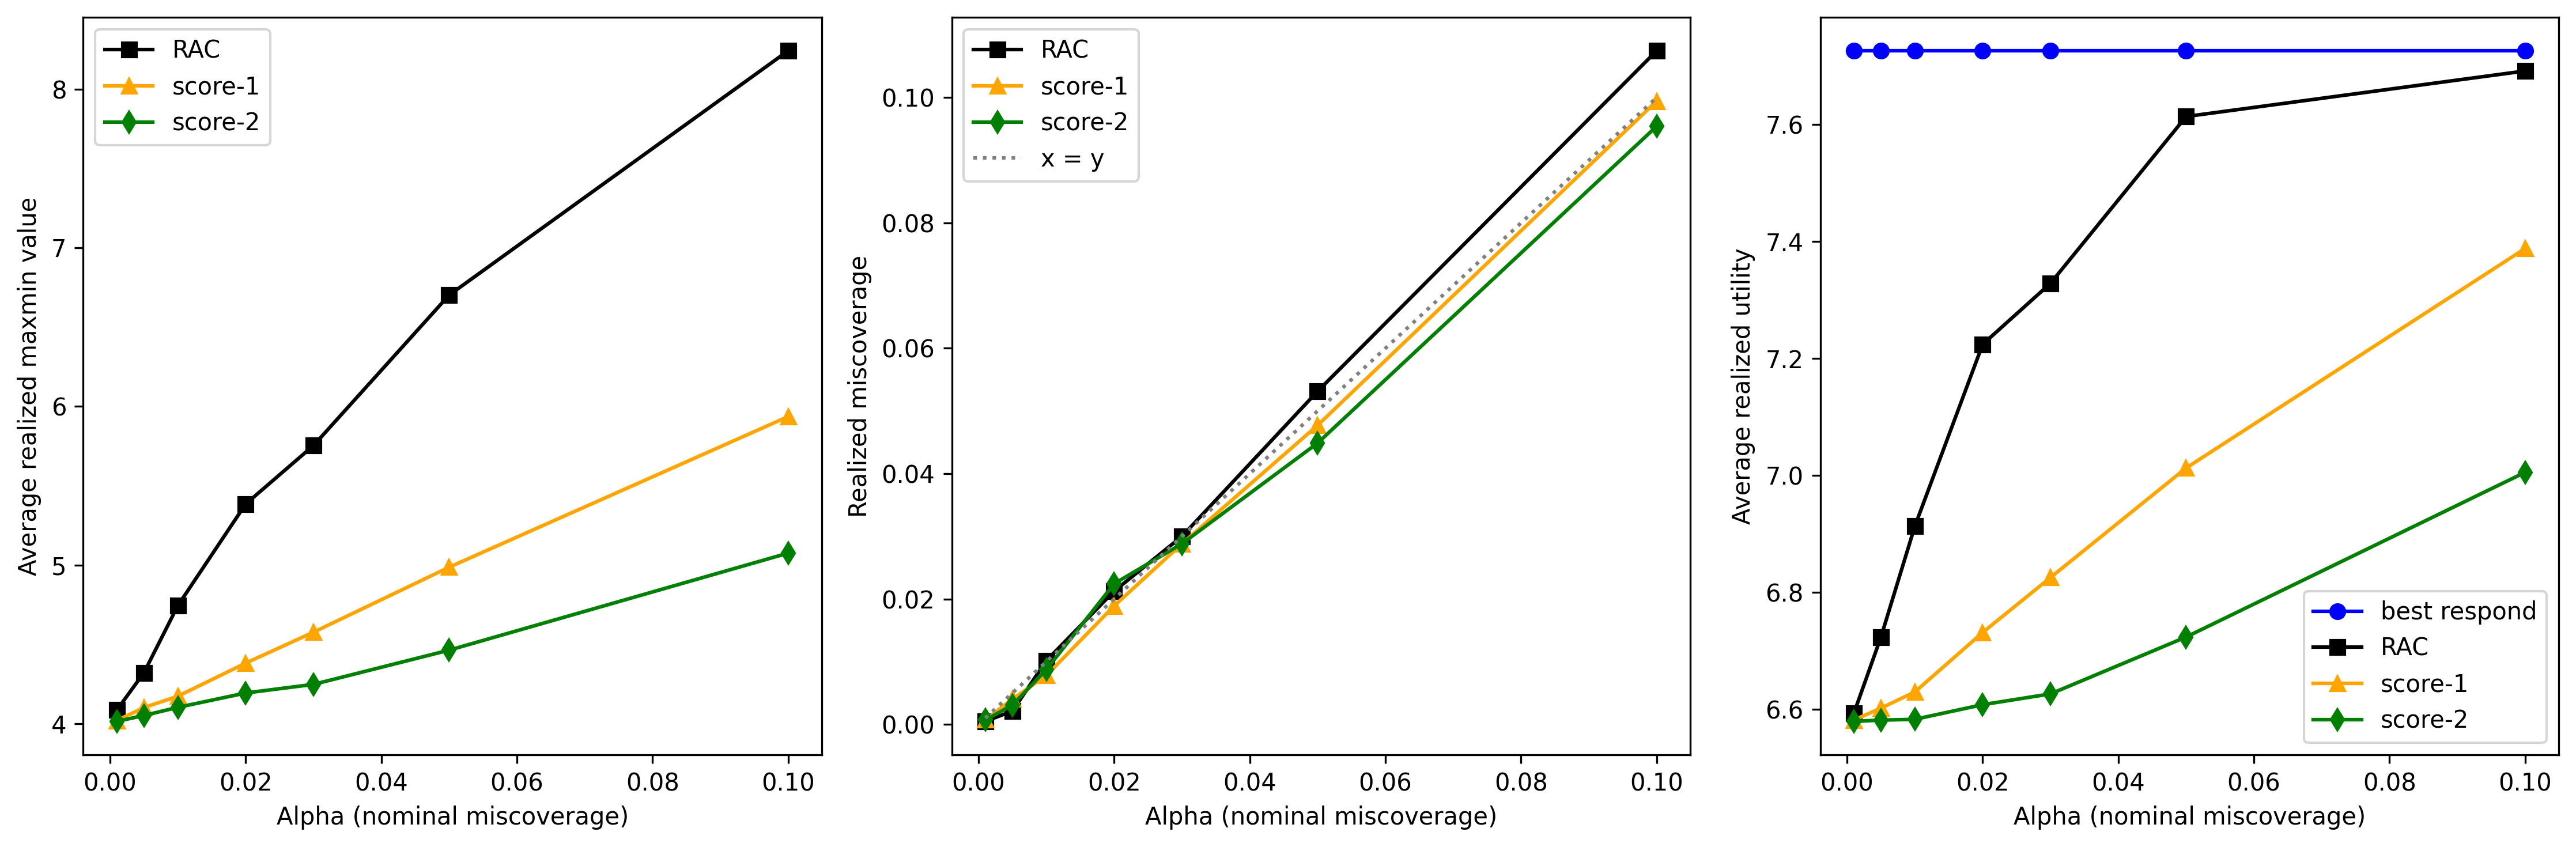

In [53]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np

# Example values (you can replace these with your actual data)
alpha_list = [0.001, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]

# Define consistent colors
colors = {
    'ours': 'black',
    'b': 'blue',
    's1': 'orange',
    's2': 'green'
}


# Create the plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=300, sharey=False)

# Plot 1: Averages
axes[2].plot(alpha_list, avg_b, label='best respond', marker='o', color=colors['b'])
axes[2].plot(alpha_list, avg_ours, label='RAC', marker='s', color=colors['ours'])
axes[2].plot(alpha_list, avg_s1, label='score-1', marker='^', color=colors['s1'])
axes[2].plot(alpha_list, avg_s2, label='score-2', marker='d', color=colors['s2'])
axes[2].set_xlabel('Alpha (nominal miscoverage)')
axes[2].set_ylabel('Average realized utility')
axes[2].legend()
# axes[0].set_xticks(alpha_list)  # Set x-axis ticks to alpha_list

# Plot 2: Q-values
axes[1].plot(alpha_list, q_ours, label='RAC', marker='s', color=colors['ours'])
axes[1].plot(alpha_list, q_s1, label='score-1', marker='^', color=colors['s1'])
axes[1].plot(alpha_list, q_s2, label='score-2', marker='d', color=colors['s2'])

# Add x = y baseline as dotted line
axes[1].plot(alpha_list, alpha_list, label='x = y', linestyle=':', color='gray')

axes[1].set_xlabel('Alpha (nominal miscoverage)')
axes[1].set_ylabel('Realized miscoverage')
# axes[1].set_title('Plot of Q-values')
axes[1].legend()
# axes[1].set_xticks(alpha_list)  # Set x-axis ticks to alpha_list

# Plot 3: Maximums
axes[0].plot(alpha_list, max_ours, label='RAC', marker='s', color=colors['ours'])
axes[0].plot(alpha_list, max_s1, label='score-1', marker='^', color=colors['s1'])
axes[0].plot(alpha_list, max_s2, label='score-2', marker='d', color=colors['s2'])
axes[0].set_xlabel('Alpha (nominal miscoverage)')
axes[0].set_ylabel('Average realized maxmin value')
axes[0].legend()
# axes[2].set_xticks(alpha_list)  # Set x-axis ticks to alpha_list

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig("icml_three_plots.pdf")
plt.show()


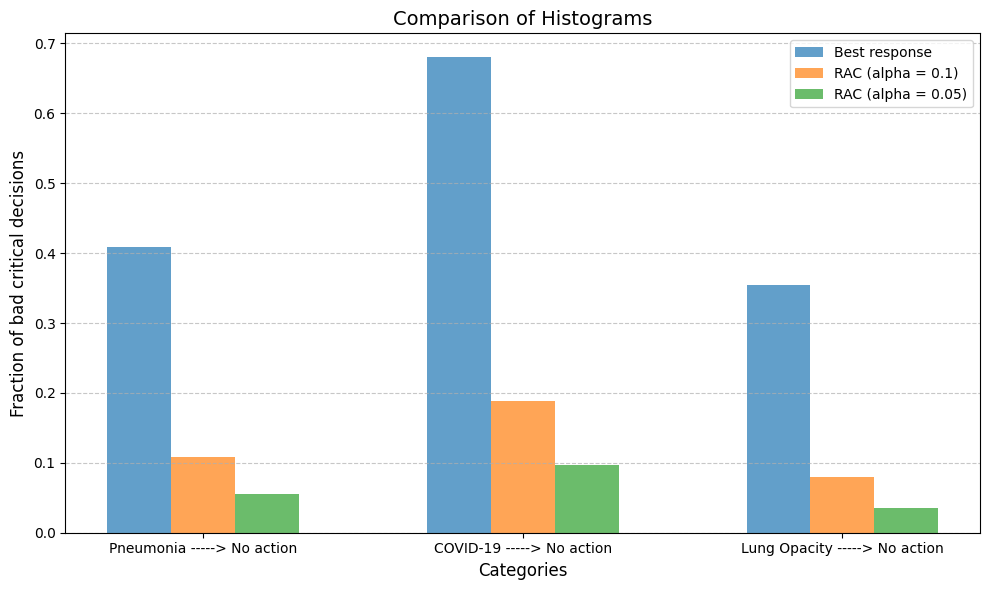

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# The following numbers are for the specific setup that is used for the paper.
#To reproduce this, or compute them for your own setup, you have to run the method of your interest with the specific value of alpha and then read the results and plug them in here.
#To run each of the methods, right after each method's implementaion in this file, there is an exmample, which helps you run the method.



# Data for Histogram 1
hist1_labels = ["Pneumonia -----> No action", "COVID-19 -----> No action", "Lung Opacity -----> No action"]
hist1_values = [110/269, 492/723, 427/1203]

# Data for Histogram 2
hist3_labels = ["Pneumonia -----> No action", "COVID-19 -----> No action", "Lung Opacity -----> No action"]
hist3_values = [15/269, 70/723, 42/1203]

# Data for Histogram 3
hist2_labels = ["Pneumonia -----> No action", "COVID-19 -----> No action", "Lung Opacity -----> No action"]
hist2_values = [29/269, 136/723, 96/1203]

# Plot settings for histograms
bar_width_hist = 0.2
x_hist1 = np.arange(len(hist1_labels))
x_hist2 = x_hist1 + bar_width_hist
x_hist3 = x_hist2 + bar_width_hist

plt.figure(figsize=(10, 6))

# Plot bars for Histogram 1
plt.bar(x_hist1, hist1_values, width=bar_width_hist, label='Best response', alpha=0.7)

# Plot bars for Histogram 2
plt.bar(x_hist2, hist2_values, width=bar_width_hist, label='RAC (alpha = 0.1)', alpha=0.7)

# Plot bars for Histogram 3
plt.bar(x_hist3, hist3_values, width=bar_width_hist, label='RAC (alpha = 0.05)', alpha=0.7)

# Add labels and title for histograms
plt.xlabel('Categories', fontsize=12)
plt.ylabel('Fraction of bad critical decisions', fontsize=12)
plt.title('Comparison of Histograms', fontsize=14)
plt.xticks(ticks=x_hist1 + bar_width_hist, labels=hist1_labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot for histograms
plt.tight_layout()
plt.show()


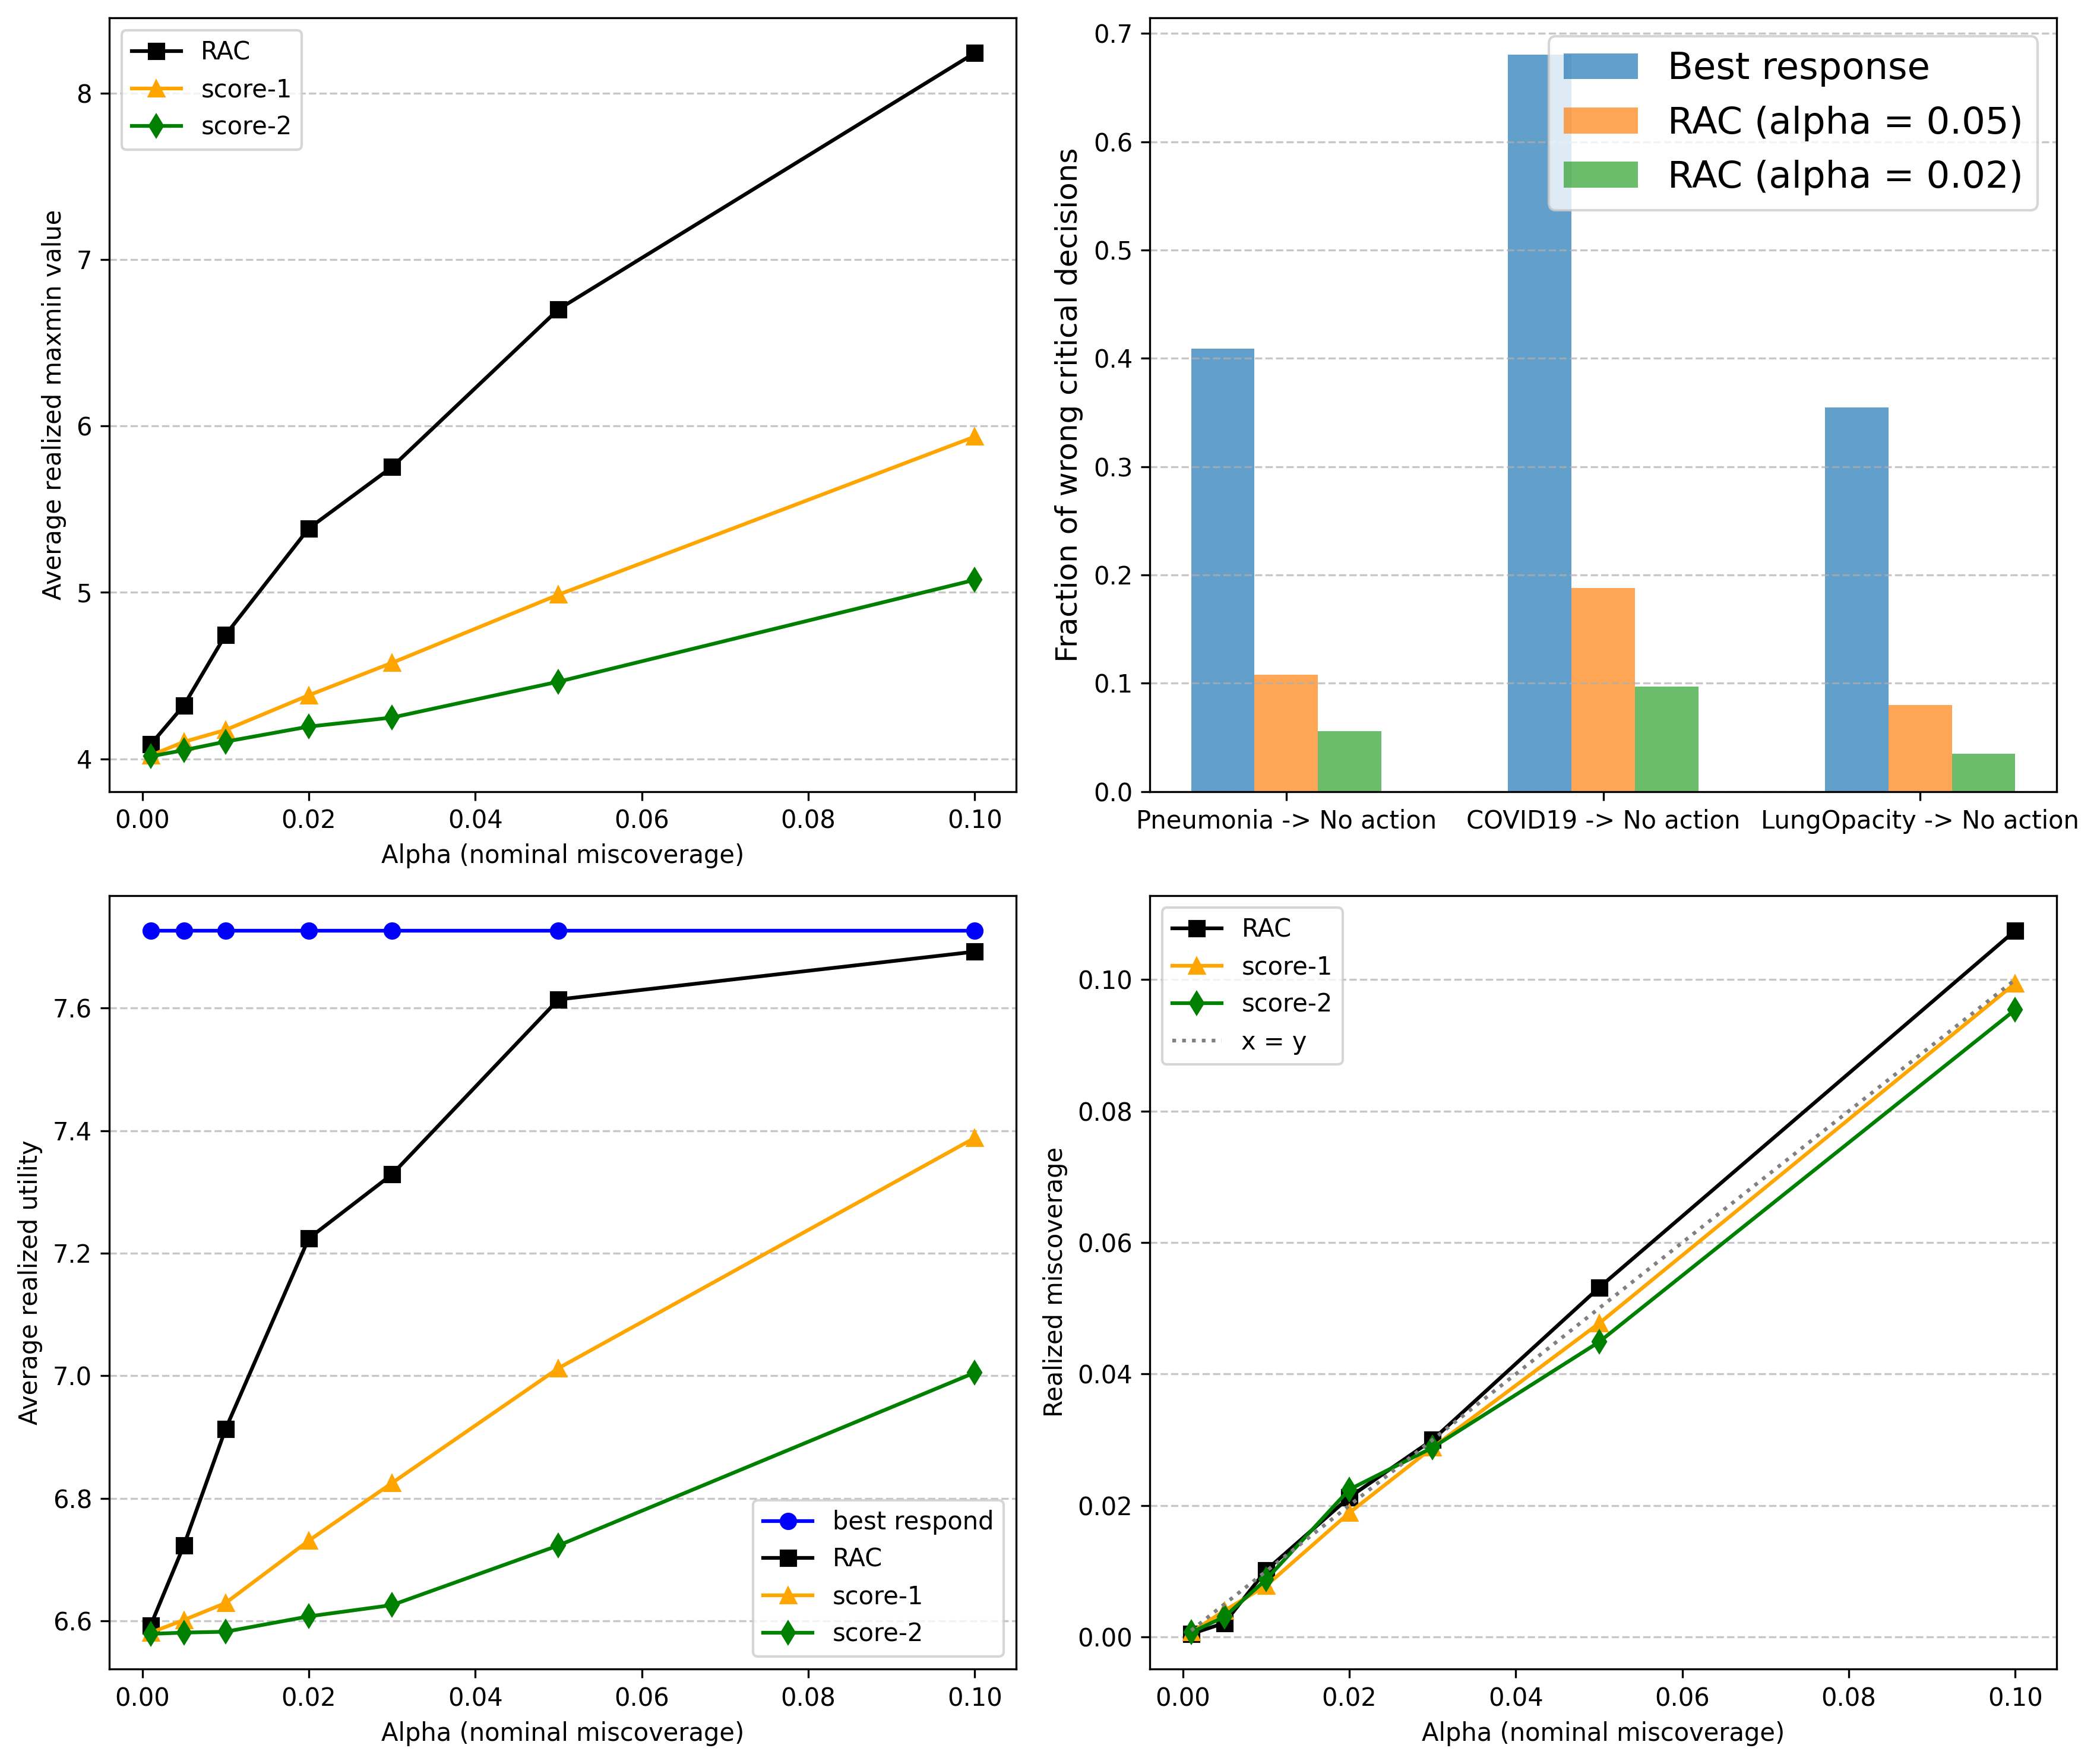

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Example values (you can replace these with your actual data)
alpha_list = [0.001, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]

# Define consistent colors
colors = {
    'ours': 'black',
    'b': 'blue',
    's1': 'orange',
    's2': 'green'
}

# The following numbers are for the specific setup that is used for the paper.
#To reproduce this, or compute them for your own setup, you have to run the method of your interest with the specific value of alpha and then read the results and plug them in here.
#To run each of the methods, right after each method's implementaion in this file, there is an exmample, which helps you run the method.


# Data for Histogram 1
hist1_labels = ["Pneumonia -> No action", "COVID19 -> No action", "LungOpacity -> No action"]
hist1_values = [110/269, 492/723, 427/1203]

# Data for Histogram 2
hist3_labels = ["Pneumonia -> No action", "COVID19 -> No action", "LungOpacity -> No action"]
hist3_values = [15/269, 70/723, 42/1203]

# Data for Histogram 3
hist2_labels = ["Pneumonia -> No action", "COVID19 -> No action", "LungOpacity -> No action"]
hist2_values = [29/269, 136/723, 96/1203]

# Combine all data for plotting
bar_width_hist = 0.2
x_hist1 = np.arange(len(hist1_labels))
x_hist2 = x_hist1 + bar_width_hist
x_hist3 = x_hist2 + bar_width_hist

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=300)

# Plot 1: Maximums
axes[0, 0].plot(alpha_list, max_ours, label='RAC', marker='s', color=colors['ours'])
axes[0, 0].plot(alpha_list, max_s1, label='score-1', marker='^', color=colors['s1'])
axes[0, 0].plot(alpha_list, max_s2, label='score-2', marker='d', color=colors['s2'])
axes[0, 0].set_xlabel('Alpha (nominal miscoverage)')
axes[0, 0].set_ylabel('Average realized maxmin value')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Q-values
axes[1, 1].plot(alpha_list, q_ours, label='RAC', marker='s', color=colors['ours'])
axes[1, 1].plot(alpha_list, q_s1, label='score-1', marker='^', color=colors['s1'])
axes[1, 1].plot(alpha_list, q_s2, label='score-2', marker='d', color=colors['s2'])
axes[1, 1].plot(alpha_list, alpha_list, label='x = y', linestyle=':', color='gray')
axes[1, 1].set_xlabel('Alpha (nominal miscoverage)')
axes[1, 1].set_ylabel('Realized miscoverage')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 3: Averages
axes[1, 0].plot(alpha_list, avg_b, label='best respond', marker='o', color=colors['b'])
axes[1, 0].plot(alpha_list, avg_ours, label='RAC', marker='s', color=colors['ours'])
axes[1, 0].plot(alpha_list, avg_s1, label='score-1', marker='^', color=colors['s1'])
axes[1, 0].plot(alpha_list, avg_s2, label='score-2', marker='d', color=colors['s2'])
axes[1, 0].set_xlabel('Alpha (nominal miscoverage)')
axes[1, 0].set_ylabel('Average realized utility')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 4: Histograms
axes[0, 1].bar(x_hist1, hist1_values, width=bar_width_hist, label='Best response', alpha=0.7)
axes[0, 1].bar(x_hist2, hist2_values, width=bar_width_hist, label='RAC (alpha = 0.05)', alpha=0.7)
axes[0, 1].bar(x_hist3, hist3_values, width=bar_width_hist, label='RAC (alpha = 0.02)', alpha=0.7)
axes[0, 1].set_ylabel('Fraction of wrong critical decisions', fontsize=12)
axes[0, 1].set_xticks(ticks=x_hist1 + bar_width_hist)
axes[0, 1].set_xticklabels(hist1_labels)
axes[0, 1].legend(fontsize = 15)
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.savefig("icml_2x2_plots_updated.pdf")
plt.show()


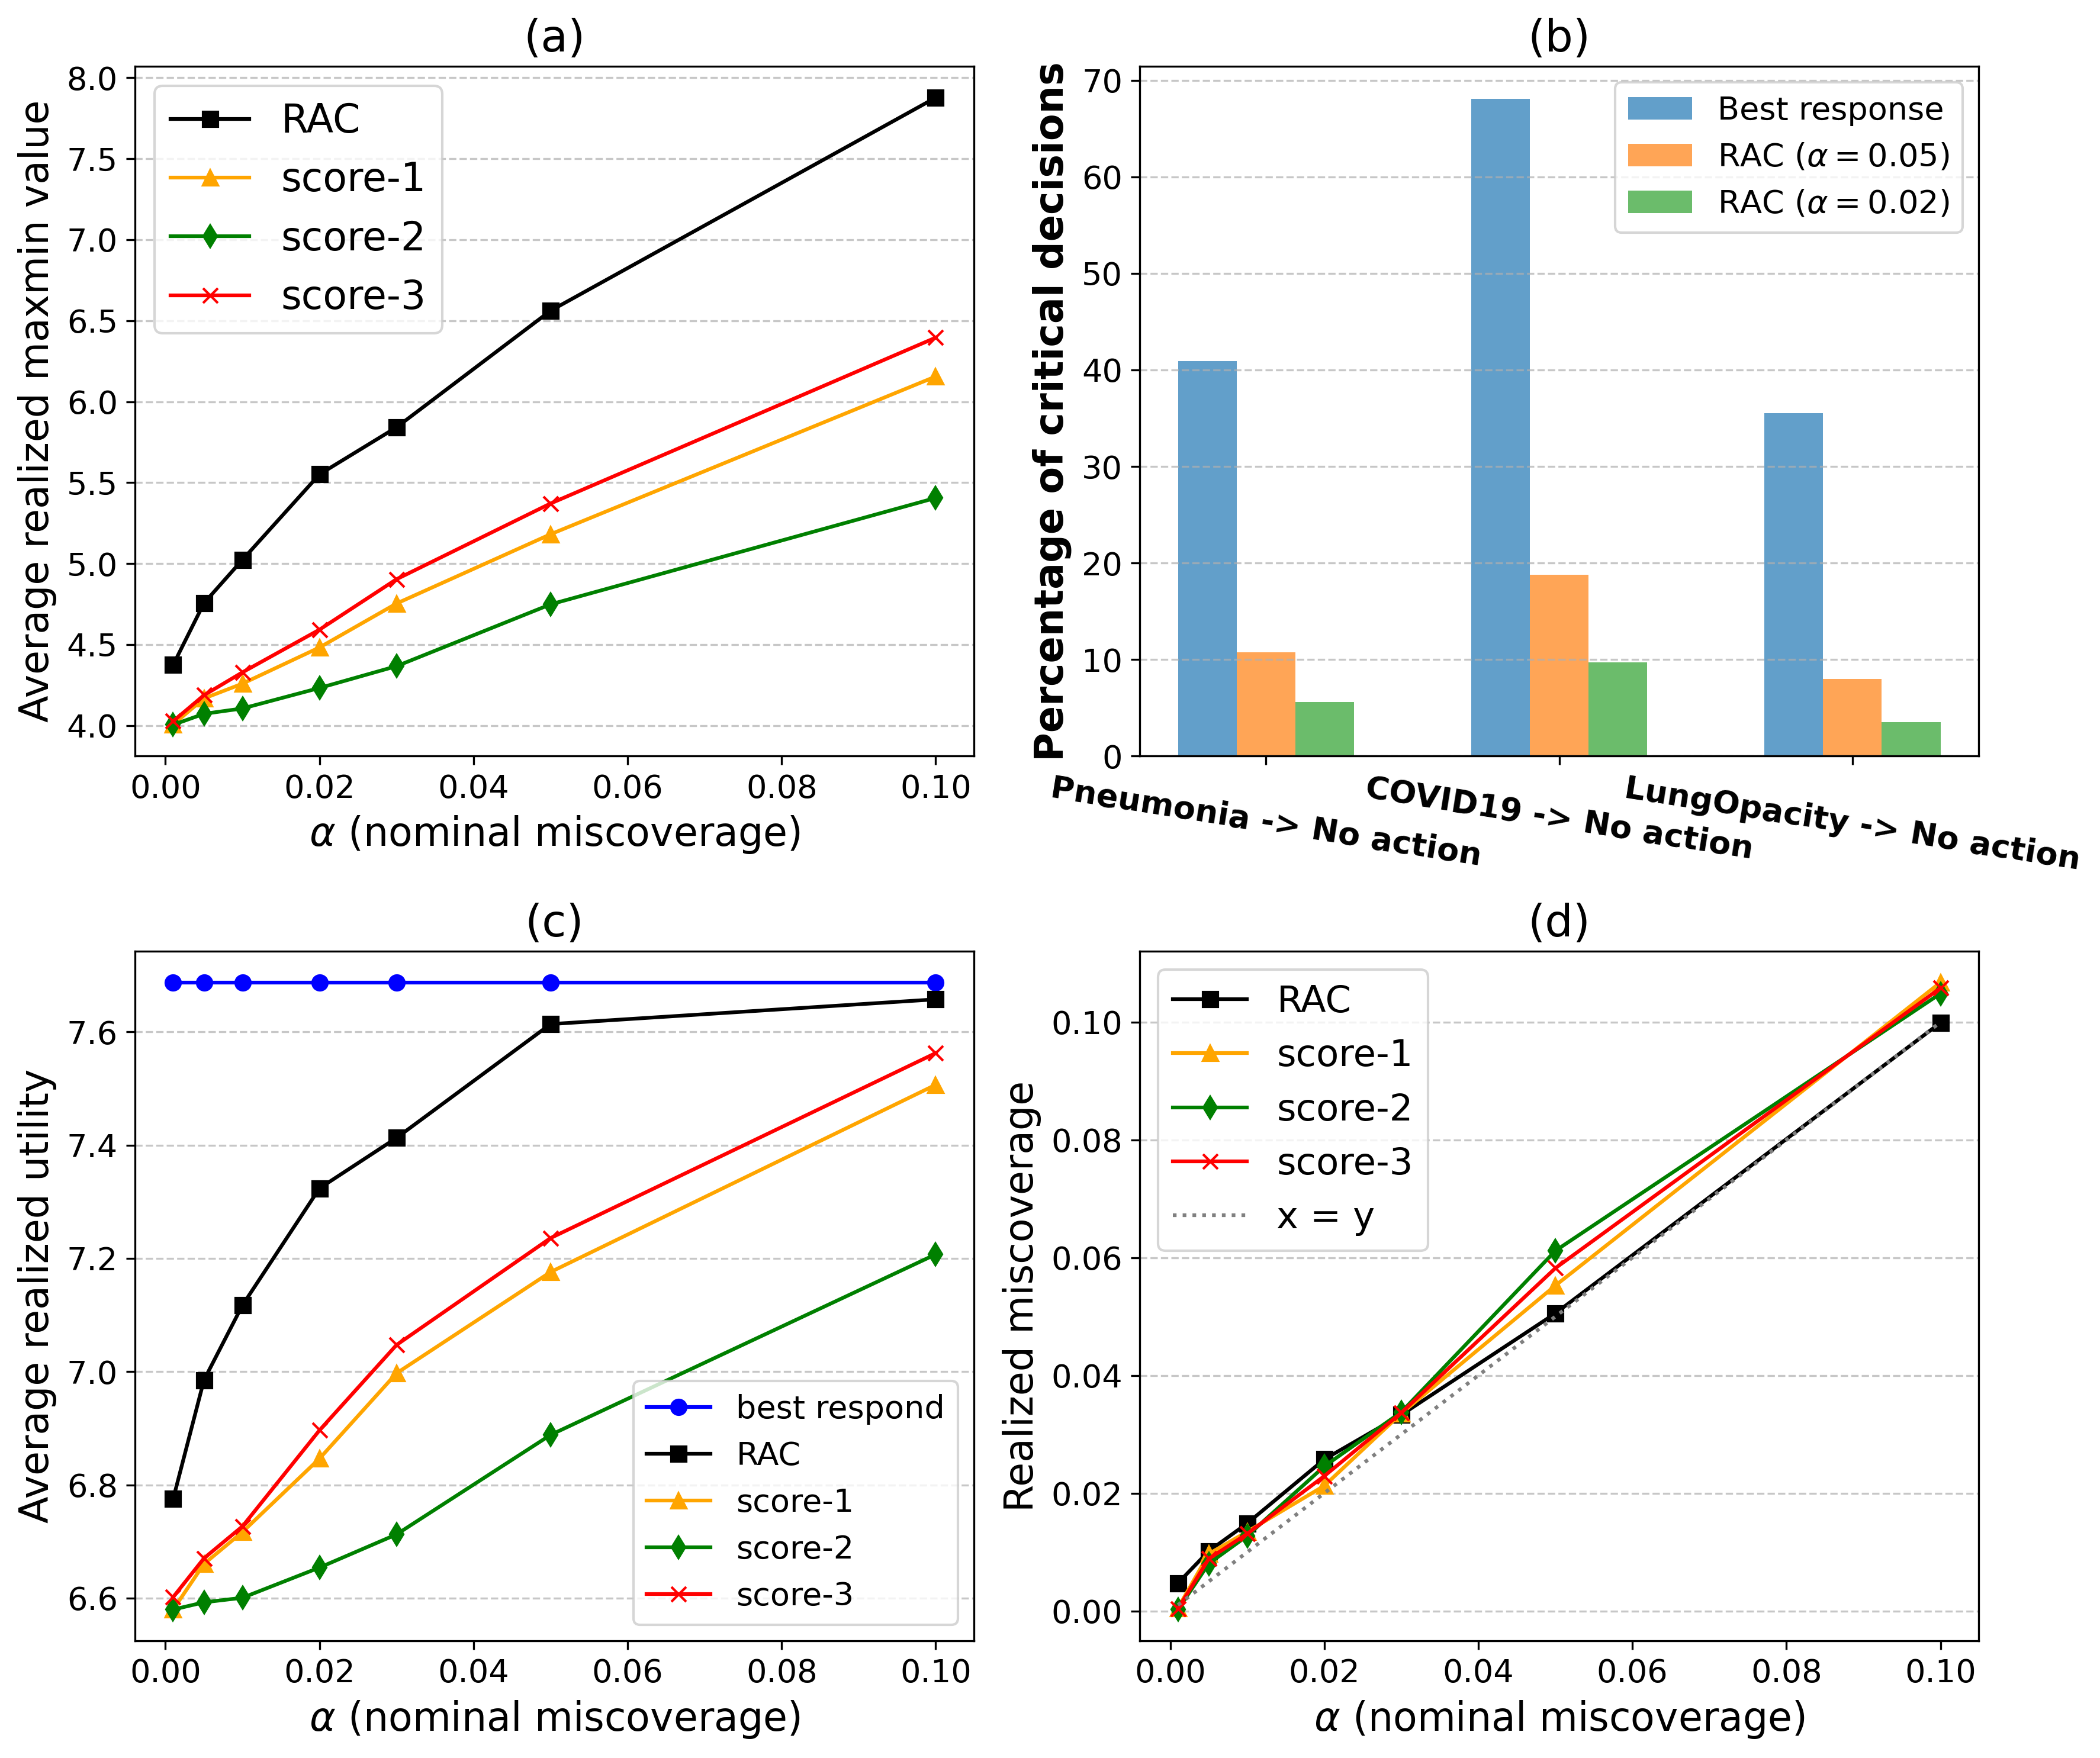

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example values (you can replace these with your actual data)
alpha_list = [0.001, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]

# Define consistent colors
colors = {
    'ours': 'black',
    'b': 'blue',
    's1': 'orange',
    's2': 'green',
    's3': 'red'
}

# Data for Histogram 1
hist1_labels = ["Pneumonia -> No action", "COVID19 -> No action", "LungOpacity -> No action"]
hist1_values = [110/269*100, 492/723*100, 427/1203*100]

# Data for Histogram 2
hist3_labels = ["Pneumonia -> No action", "COVID19 -> No action", "LungOpacity -> No action"]
hist3_values = [15/269*100, 70/723*100, 42/1203*100]

# Data for Histogram 3
hist2_labels = ["Pneumonia -> No action", "COVID19 -> No action", "LungOpacity -> No action"]
hist2_values = [29/269*100, 136/723*100, 96/1203*100]

# Combine all data for plotting
bar_width_hist = 0.2
x_hist1 = np.arange(len(hist1_labels))
x_hist2 = x_hist1 + bar_width_hist
x_hist3 = x_hist2 + bar_width_hist

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=300)

# Plot 1: Maximums
axes[0, 0].plot(alpha_list, max_ours, label='RAC', marker='s', color=colors['ours'])
axes[0, 0].plot(alpha_list, max_s1, label='score-1', marker='^', color=colors['s1'])
axes[0, 0].plot(alpha_list, max_s2, label='score-2', marker='d', color=colors['s2'])
axes[0, 0].plot(alpha_list, max_s3, label='score-3', marker='x', color=colors['s3'])
axes[0, 0].set_xlabel(r'$\alpha$ (nominal miscoverage)', fontsize = 16)
axes[0, 0].set_ylabel('Average realized maxmin value', fontsize = 16)
axes[0, 0].legend(fontsize = 16)
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Q-values
axes[1, 1].plot(alpha_list, q_ours, label='RAC', marker='s', color=colors['ours'])
axes[1, 1].plot(alpha_list, q_s1, label='score-1', marker='^', color=colors['s1'])
axes[1, 1].plot(alpha_list, q_s2, label='score-2', marker='d', color=colors['s2'])
axes[1, 1].plot(alpha_list, q_s3, label='score-3', marker='x', color=colors['s3'])
axes[1, 1].plot(alpha_list, alpha_list, label='x = y', linestyle=':', color='gray')
axes[1, 1].set_xlabel(r'$\alpha$ (nominal miscoverage)', fontsize = 16)  # X-axis label bold
axes[1, 1].set_ylabel('Realized miscoverage', fontsize = 16)
axes[1, 1].legend(fontsize = 15)
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 3: Averages
axes[1, 0].plot(alpha_list, avg_b, label='best respond', marker='o', color=colors['b'])
axes[1, 0].plot(alpha_list, avg_ours, label='RAC', marker='s', color=colors['ours'])
axes[1, 0].plot(alpha_list, avg_s1, label='score-1', marker='^', color=colors['s1'])
axes[1, 0].plot(alpha_list, avg_s2, label='score-2', marker='d', color=colors['s2'])
axes[1, 0].plot(alpha_list, avg_s3, label='score-3', marker='x', color=colors['s3'])
axes[1, 0].set_xlabel(r'$\alpha$ (nominal miscoverage)', fontsize = 16)
axes[1, 0].set_ylabel('Average realized utility', fontsize = 16)
axes[1, 0].legend(fontsize = 13)
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 4: Histograms
axes[0, 1].bar(x_hist1, hist1_values, width=bar_width_hist, label='Best response', alpha=0.7)
axes[0, 1].bar(x_hist2, hist2_values, width=bar_width_hist, label=r'RAC ($\alpha = 0.05$)', alpha=0.7)
axes[0, 1].bar(x_hist3, hist3_values, width=bar_width_hist, label=r'RAC ($\alpha = 0.02$)', alpha=0.7)
axes[0, 1].set_ylabel('Percentage of critical decisions', fontsize=16, fontweight='bold')
axes[0, 1].set_xticks(ticks=x_hist1 + bar_width_hist)
axes[0, 1].set_xticklabels(hist1_labels, fontweight='bold', rotation = -9, fontsize = 11)
axes[0, 1].legend(fontsize = 13)
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)
for ax in axes.flat:
    ax.tick_params(axis='both', labelsize=13)  # Increase font size of both x and y ticks

axes[0, 1].set_title('(b)', fontsize=18)
axes[1, 0].set_title('(c)', fontsize=18)
axes[1, 1].set_title('(d)', fontsize=18)
axes[0, 0].set_title('(a)', fontsize=18)

# Adjust layout
plt.tight_layout()
plt.savefig("icml_2x2_plots_medical.pdf")
plt.show()


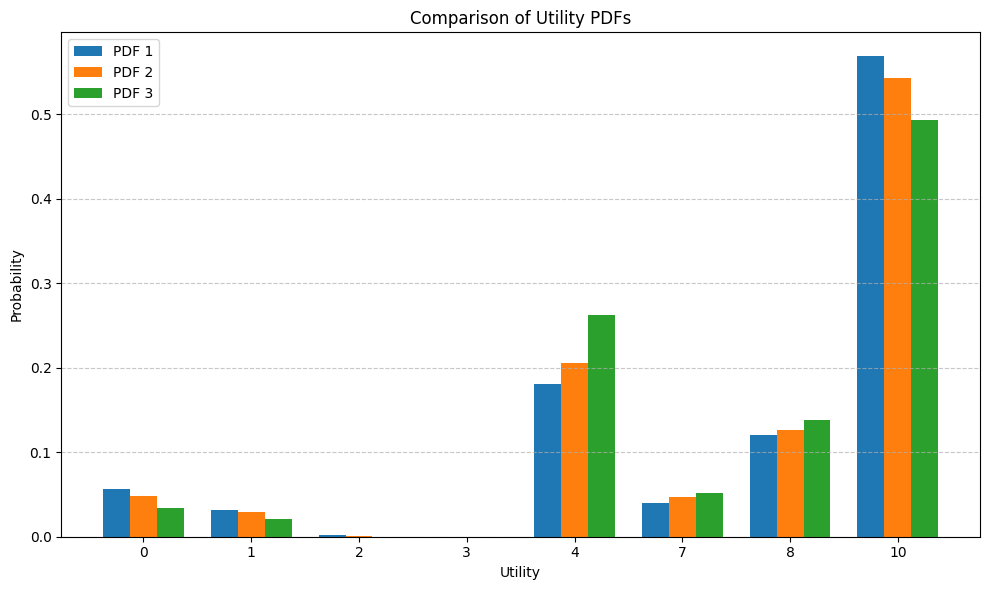

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define utilities and probabilities
utilities = sorted(list({0, 1, 2, 3, 4, 7, 8, 10}))

pdf1 = {0: 0.0484, 1: 0.0291, 2: 0.0005, 4: 0.2052, 7: 0.0472, 8: 0.1268, 10: 0.5427}
pdf2 = {0: 0.0340, 1: 0.0210, 4: 0.2622, 7: 0.0513, 8: 0.1386, 10: 0.4929}
pdf3 = {0: 0.0560, 1: 0.0321, 2: 0.0019, 3: 0.0002, 4: 0.1807, 7: 0.0404, 8: 0.1202, 10: 0.5685}

# Create probability lists aligned with all utilities
prob1 = [pdf1.get(u, 0) for u in utilities]
prob2 = [pdf2.get(u, 0) for u in utilities]
prob3 = [pdf3.get(u, 0) for u in utilities]

# Bar positions
x = np.arange(len(utilities))
width = 0.25

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, prob3, width, label='PDF 1')
ax.bar(x, prob1, width, label='PDF 2')
ax.bar(x + width, prob2, width, label='PDF 3')

# Labels and titles
ax.set_xlabel('Utility')
ax.set_ylabel('Probability')
ax.set_title('Comparison of Utility PDFs')
ax.set_xticks(x)
ax.set_xticklabels(utilities)
ax.legend()

# Grid and layout adjustments
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()


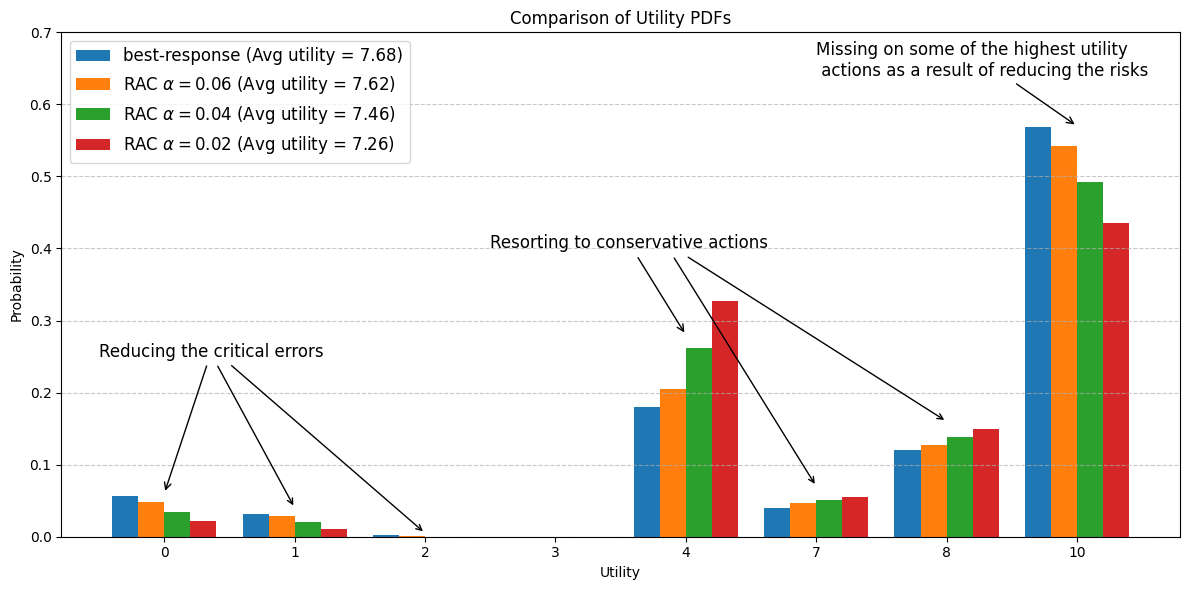

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define utilities and probabilities
utilities = sorted(list({0, 1, 2, 3, 4, 7, 8, 10}))

pdf1 = {0: 0.0484, 1: 0.0291, 2: 0.0005, 4: 0.2052, 7: 0.0472, 8: 0.1268, 10: 0.5427}
pdf2 = {0: 0.0340, 1: 0.0210, 4: 0.2622, 7: 0.0513, 8: 0.1386, 10: 0.4929}
pdf3 = {0: 0.0560, 1: 0.0321, 2: 0.0019, 3: 0.0002, 4: 0.1807, 7: 0.0404, 8: 0.1202, 10: 0.5685}
pdf4 = {0: 0.0215, 1: 0.0106, 4: 0.3271, 7: 0.0548, 8: 0.1500, 10: 0.4360}

# Create probability lists aligned with all utilities
prob1 = [pdf1.get(u, 0) for u in utilities]
prob2 = [pdf2.get(u, 0) for u in utilities]
prob3 = [pdf3.get(u, 0) for u in utilities]
prob4 = [pdf4.get(u, 0) for u in utilities]

# Bar positions
x = np.arange(len(utilities))
width = 0.2

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - 1.5*width, prob3, width, label='best-response (Avg utility = 7.68)')
ax.bar(x - 0.5*width, prob1, width, label=r'RAC $\alpha = 0.06$ (Avg utility = 7.62)')
ax.bar(x + 0.5*width, prob2, width, label=r'RAC $\alpha = 0.04$ (Avg utility = 7.46)')
ax.bar(x + 1.5*width, prob4, width, label=r'RAC $\alpha = 0.02$ (Avg utility = 7.26)')

# Labels and titles
ax.set_xlabel('Utility')
ax.set_ylabel('Probability')
ax.set_title('Comparison of Utility PDFs')
ax.set_xticks(x)
ax.set_xticklabels(utilities)
ax.legend(loc='upper left', fontsize= 12)
ax.set_ylim([0.0, 0.7])

# Grid and layout adjustments
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

ax.annotate('Reducing the critical errors', xy=(0, 0.06), xytext=(-0.5, 0.25),
            arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)
ax.annotate('', xy=(1, 0.04), xytext=(0.4, 0.24),
            arrowprops=dict(facecolor='black', arrowstyle='->'))
ax.annotate('', xy=(2, 0.005), xytext=(0.5, 0.24),
            arrowprops=dict(facecolor='black', arrowstyle='->'))

ax.annotate('Resorting to conservative actions', xy=(4, 0.28), xytext=(2.5, 0.40),
            arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)
ax.annotate('', xy=(5, 0.07), xytext=(3.9, 0.39),
            arrowprops=dict(facecolor='black', arrowstyle='->'))
ax.annotate('', xy=(6, 0.16), xytext=(4.0, 0.39),
            arrowprops=dict(facecolor='black', arrowstyle='->'))

ax.annotate('Missing on some of the highest utility\n actions as a result of reducing the risks', xy=(7, 0.57), xytext=(5.0, 0.64),
            arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)
# Show plot
plt.savefig("icml_rebuttal_risk.pdf")
# plt.show()
